## [Dacon] 블럭 장난감 제조 공정 최적화 경진대회
## _____ (팀명)
## 2020년 월 일 (제출날짜)

1. 본 코드는 대회 참가를 돕고자 단순 예시를 작성한 것으로 참고용으로 사용바랍니다.
2. 본 코드는 자유롭게 수정하여 사용 할 수 있습니다.
3. 추가 모듈 보러가기: https://bit.ly/36MNs76

## 1. 라이브러리 및 데이터
## Library & Data

In [1]:
import pandas as pd
import numpy as np
import multiprocessing
import warnings
from copy import deepcopy
from module.genome import Genome, genome_score
warnings.filterwarnings(action='ignore')
np.random.seed(777)

In [2]:
!python --version
print('Pandas : %s'%(pd.__version__))
print('Numpy : %s'%(np.__version__))

Python 3.7.4
Pandas : 1.0.4
Numpy : 1.18.5


## 2. 데이터 전처리
## Data Cleansing & Pre-Processing  

In [4]:
# 입력하세요.

## 3. 탐색적 자료분석
## Exploratory Data Analysis

In [4]:
# 입력하세요.

## 4. 변수 선택 및 모델 구축
## Feature Engineering & Initial Modeling  

In [3]:
# CPU_CORE = multiprocessing.cpu_count() # 멀티프로세싱 CPU 사용 수
CPU_CORE = 5
N_POPULATION = 50                      # 세대당 생성수
N_BEST = 5                             # 베스트 수
N_CHILDREN = 5                         # 자손 유전자 수
PROB_MUTATION = 0.5                    # 돌연변이
REVERSE = True                         # 배열 순서 (False: ascending order, True: descending order)

score_ini = 0                          # 초기 점수
input_length = 125                     # 입력 데이터 길이
output_length_1 = 6                    # Event (CHECK_1~4, PROCESS)
output_length_2 = 29                   # MOL(0~5.5, step:0.5)
h1 = 50                                # 히든레이어1 노드 수
h2 = 50                                # 히든레이어2 노드 수
h3 = 50                                # 히든레이어3 노드 수
EPOCHS = 50                            # 반복 횟수

#best_genomes 초기화
best_genomes=[]
# 고쳐보자
genomes = []
for _ in range(N_POPULATION):
    genome = Genome(score_ini, input_length, output_length_1, output_length_2, h1, h2, h3)
    genomes.append(genome)
try:
    for i in range(N_BEST):
        genomes[i] = best_genomes[i]
except:
    # best_genome 초기화하고 채우기
    # 이거 한 번 해둔 상태면 이 cell 다시 돌려도 best_genomes 안변한다ㅠ 초기화해야된다
    best_genomes = []
    for _ in range(5):
        genome = Genome(score_ini, input_length, output_length_1, output_length_2, h1, h2, h3)
        best_genomes.append(genome)
for _ in best_genomes:
    print(_)

## 5. 모델 학습 및 검증
## Model Tuning & Evaluation
1. PRT는 고정값 사용
2. Event A, Event B (MOL_A, MOL_B) 를 같은 값으로 제한
3. Event는 CHECK와 PROCESS 만 사용함
4. 목적 함수로 수요 부족분만 고려함
5. Event와 MOL에 대해 인공신경망 모델을 만들어 유전 알고리즘으로 학습

In [4]:
n_gen = 1
score_history = []
high_score_history = []
mean_score_history = []
while n_gen <= EPOCHS:    
    genomes = np.array(genomes)    
    while len(genomes)%CPU_CORE != 0:
        genomes = np.append(genomes, Genome(score_ini, input_length, output_length_1, output_length_2, h1, h2, h3))
    genomes = genomes.reshape((len(genomes)//CPU_CORE, CPU_CORE))
    
    for idx, _genomes in enumerate(genomes):
        if __name__ == '__main__':
            pool = multiprocessing.Pool(processes=CPU_CORE)
            genomes[idx] = pool.map(genome_score, _genomes)
            pool.close()
            pool.join()    
    genomes = list(genomes.reshape(genomes.shape[0]*genomes.shape[1]))    
    
     # score에 따라 정렬
    genomes.sort(key=lambda x: x.score, reverse=REVERSE)
    
    # 평균 점수
    s = 0 
    for i in range(N_BEST):
        s += genomes[i].score
    s /= N_BEST
    
    # Best Score
    bs = genomes[0].score 
    
    # Best Model 추가
    if best_genomes is not None:
        genomes.extend(best_genomes)
        
    # score에 따라 정렬
    genomes.sort(key=lambda x: x.score, reverse=REVERSE)
    
    score_history.append([n_gen, genomes[0].score])
    high_score_history.append([n_gen, bs])
    mean_score_history.append([n_gen, s])
    
    # 결과 출력
    print('EPOCH #%s\tHistory Best Score: %s\tBest Score: %s\tMean Score: %s' % (n_gen, genomes[0].score, bs, s))    
    
    # 모델 업데이트
    best_genomes = deepcopy(genomes[:N_BEST]) #5개
    
    # CHILDREN 생성 (LINE A)
    for i in range(N_CHILDREN):
        new_genome = deepcopy(best_genomes[0])
        a_genome = np.random.choice(best_genomes)
        b_genome = np.random.choice(best_genomes)
        
        for j in range(input_length):
            cut = np.random.randint(new_genome.w1_1.shape[1])
            new_genome.w1_1[j, :cut] = a_genome.w1_1[j, :cut]
            new_genome.w1_1[j, cut:] = b_genome.w1_1[j, cut:]
        
        for j in range(h1):
            cut = np.random.randint(new_genome.w2_1.shape[1])
            new_genome.w2_1[j, :cut] = a_genome.w2_1[j, :cut]
            new_genome.w2_1[j, cut:] = b_genome.w2_1[j, cut:]
        
        for j in range(h2):
            cut = np.random.randint(new_genome.w3_1.shape[1])
            new_genome.w3_1[j, :cut] = a_genome.w3_1[j, :cut]
            new_genome.w3_1[j, cut:] = b_genome.w3_1[j, cut:]
        
        for j in range(h3):
            cut = np.random.randint(new_genome.w4_1.shape[1])
            new_genome.w4_1[j, :cut] = a_genome.w4_1[j, :cut]
            new_genome.w4_1[j, cut:] = b_genome.w4_1[j, cut:]
            
        for j in range(input_length):
            cut = np.random.randint(new_genome.w5_1.shape[1])
            new_genome.w5_1[j, :cut] = a_genome.w5_1[j, :cut]
            new_genome.w5_1[j, cut:] = b_genome.w5_1[j, cut:]
        
        for j in range(h1):
            cut = np.random.randint(new_genome.w6_1.shape[1])
            new_genome.w6_1[j, :cut] = a_genome.w6_1[j, :cut]
            new_genome.w6_1[j, cut:] = b_genome.w6_1[j, cut:]
        
        for j in range(h2):
            cut = np.random.randint(new_genome.w7_1.shape[1])
            new_genome.w7_1[j, :cut] = a_genome.w7_1[j, :cut]
            new_genome.w7_1[j, cut:] = b_genome.w7_1[j, cut:]
        
        for j in range(h3):
            cut = np.random.randint(new_genome.w8_1.shape[1])
            new_genome.w8_1[j, :cut] = a_genome.w8_1[j, :cut]
            new_genome.w8_1[j, cut:] = b_genome.w8_1[j, cut:]
            
            # CHILDREN 생성
        for i in range(N_CHILDREN):
            new_genome = deepcopy(best_genomes[0])
            a_genome = np.random.choice(best_genomes)
            b_genome = np.random.choice(best_genomes)
        
        for j in range(input_length):
            cut = np.random.randint(new_genome.w1_2.shape[1])
            new_genome.w1_2[j, :cut] = a_genome.w1_2[j, :cut]
            new_genome.w1_2[j, cut:] = b_genome.w1_2[j, cut:]
        
        for j in range(h1):
            cut = np.random.randint(new_genome.w2_2.shape[1])
            new_genome.w2_2[j, :cut] = a_genome.w2_2[j, :cut]
            new_genome.w2_2[j, cut:] = b_genome.w2_2[j, cut:]
        
        for j in range(h2):
            cut = np.random.randint(new_genome.w3_2.shape[1])
            new_genome.w3_2[j, :cut] = a_genome.w3_2[j, :cut]
            new_genome.w3_2[j, cut:] = b_genome.w3_2[j, cut:]
        
        for j in range(h3):
            cut = np.random.randint(new_genome.w4_2.shape[1])
            new_genome.w4_2[j, :cut] = a_genome.w4_2[j, :cut]
            new_genome.w4_2[j, cut:] = b_genome.w4_2[j, cut:]
            
        for j in range(input_length):
            cut = np.random.randint(new_genome.w5_2.shape[1])
            new_genome.w5_2[j, :cut] = a_genome.w5_2[j, :cut]
            new_genome.w5_2[j, cut:] = b_genome.w5_2[j, cut:]
        
        for j in range(h1):
            cut = np.random.randint(new_genome.w6_2.shape[1])
            new_genome.w6_2[j, :cut] = a_genome.w6_2[j, :cut]
            new_genome.w6_2[j, cut:] = b_genome.w6_2[j, cut:]
        
        for j in range(h2):
            cut = np.random.randint(new_genome.w7_2.shape[1])
            new_genome.w7_2[j, :cut] = a_genome.w7_2[j, :cut]
            new_genome.w7_2[j, cut:] = b_genome.w7_2[j, cut:]
        
        for j in range(h3):
            cut = np.random.randint(new_genome.w8_2.shape[1])
            new_genome.w8_2[j, :cut] = a_genome.w8_2[j, :cut]
            new_genome.w8_2[j, cut:] = b_genome.w8_2[j, cut:]
        
        best_genomes.append(new_genome) # 10개!
    
    # 모델 초기화
    genomes = []
    for i in range(int(N_POPULATION / len(best_genomes))):
        for bg in best_genomes:
            new_genome = deepcopy(bg)            
            mean = 0
            stddev = 0.2                        
            # 50% 확률로 모델 변형
            if np.random.uniform(0, 1) < PROB_MUTATION:
                new_genome.w1_1 += new_genome.w1_1 * np.random.normal(mean, stddev, size=(input_length, h1)) * np.random.randint(0, 2, (input_length, h1))
            if np.random.uniform(0, 1) < PROB_MUTATION:
                new_genome.w2_1 += new_genome.w2_1 * np.random.normal(mean, stddev, size=(h1, h2)) * np.random.randint(0, 2, (h1, h2))
            if np.random.uniform(0, 1) < PROB_MUTATION:
                new_genome.w3_1 += new_genome.w3_1 * np.random.normal(mean, stddev, size=(h2, h3)) * np.random.randint(0, 2, (h2, h3))
            if np.random.uniform(0, 1) < PROB_MUTATION:
                new_genome.w4_1 += new_genome.w4_1 * np.random.normal(mean, stddev, size=(h3, output_length_1)) * np.random.randint(0, 2, (h3, output_length_1))                
            if np.random.uniform(0, 1) < PROB_MUTATION:
                new_genome.w5_1 += new_genome.w5_1* np.random.normal(mean, stddev, size=(input_length, h1)) * np.random.randint(0, 2, (input_length, h1))
            if np.random.uniform(0, 1) < PROB_MUTATION:
                new_genome.w6_1 += new_genome.w6_1 * np.random.normal(mean, stddev, size=(h1, h2)) * np.random.randint(0, 2, (h1, h2))
            if np.random.uniform(0, 1) < PROB_MUTATION:
                new_genome.w7_1 += new_genome.w7_1 * np.random.normal(mean, stddev, size=(h2, h3)) * np.random.randint(0, 2, (h2, h3))
            if np.random.uniform(0, 1) < PROB_MUTATION:
                new_genome.w8_1 += new_genome.w8_1 * np.random.normal(mean, stddev, size=(h3, output_length_2)) * np.random.randint(0, 2, (h3, output_length_2))
            if np.random.uniform(0, 1) < PROB_MUTATION:
                new_genome.w1_2 += new_genome.w1_2 * np.random.normal(mean, stddev, size=(input_length, h1)) * np.random.randint(0, 2, (input_length, h1))
            if np.random.uniform(0, 1) < PROB_MUTATION:
                new_genome.w2_2 += new_genome.w2_2 * np.random.normal(mean, stddev, size=(h1, h2)) * np.random.randint(0, 2, (h1, h2))
            if np.random.uniform(0, 1) < PROB_MUTATION:
                new_genome.w3_2 += new_genome.w3_2 * np.random.normal(mean, stddev, size=(h2, h3)) * np.random.randint(0, 2, (h2, h3))
            if np.random.uniform(0, 1) < PROB_MUTATION:
                new_genome.w4_2 += new_genome.w4_2 * np.random.normal(mean, stddev, size=(h3, output_length_1)) * np.random.randint(0, 2, (h3, output_length_1))                
            if np.random.uniform(0, 1) < PROB_MUTATION:
                new_genome.w5_2 += new_genome.w5_2* np.random.normal(mean, stddev, size=(input_length, h1)) * np.random.randint(0, 2, (input_length, h1))
            if np.random.uniform(0, 1) < PROB_MUTATION:
                new_genome.w6_2 += new_genome.w6_2 * np.random.normal(mean, stddev, size=(h1, h2)) * np.random.randint(0, 2, (h1, h2))
            if np.random.uniform(0, 1) < PROB_MUTATION:
                new_genome.w7_2 += new_genome.w7_2 * np.random.normal(mean, stddev, size=(h2, h3)) * np.random.randint(0, 2, (h2, h3))
            if np.random.uniform(0, 1) < PROB_MUTATION:
                new_genome.w8_2 += new_genome.w8_2 * np.random.normal(mean, stddev, size=(h3, output_length_2)) * np.random.randint(0, 2, (h3, output_length_2))
            genomes.append(new_genome)
            
    if REVERSE:
        if bs < score_ini:
            genomes[len(genomes)//2:] = [Genome(score_ini, input_length, output_length_1, output_length_2, h1, h2, h3) for _ in range(N_POPULATION//2)]
    else:
        if bs > score_ini:
            genomes[len(genomes)//2:] = [Genome(score_ini, input_length, output_length_1, output_length_2, h1, h2, h3) for _ in range(N_POPULATION//2)]  
        
    n_gen += 1

EPOCH #1	History Best Score: 57.72627499479702	Best Score: 57.72627499479702	Mean Score: 55.93285881848433
EPOCH #2	History Best Score: 60.49943979923093	Best Score: 60.49943979923093	Mean Score: 59.20882041646816
EPOCH #3	History Best Score: 61.605031883979606	Best Score: 61.605031883979606	Mean Score: 61.06730298428643
EPOCH #4	History Best Score: 62.936740169144684	Best Score: 62.936740169144684	Mean Score: 62.53847757491898
EPOCH #5	History Best Score: 62.936740169144684	Best Score: 62.92563599760743	Mean Score: 62.64993986328459
EPOCH #6	History Best Score: 63.31317941815923	Best Score: 63.31317941815923	Mean Score: 62.54778953409176
EPOCH #7	History Best Score: 63.789411207026056	Best Score: 63.789411207026056	Mean Score: 63.01930694147268
EPOCH #8	History Best Score: 64.19483281993116	Best Score: 64.19483281993116	Mean Score: 63.72175658808086
EPOCH #9	History Best Score: 64.19483281993116	Best Score: 64.15411373534869	Mean Score: 63.80384002497018
EPOCH #10	History Best Score: 

## 6. 결과 및 결언
## Conclusion & Discussion

### 결과 그래프

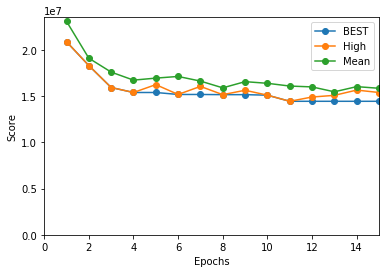

In [5]:
import matplotlib.pyplot as plt

# Score Graph
score_history = np.array(score_history)
high_score_history = np.array(high_score_history)
mean_score_history = np.array(mean_score_history)

plt.plot(score_history[:,0], score_history[:,1], '-o', label='BEST')
plt.plot(high_score_history[:,0], high_score_history[:,1], '-o', label='High')
plt.plot(mean_score_history[:,0], mean_score_history[:,1], '-o', label='Mean')
plt.legend()
plt.xlim(0, EPOCHS)
plt.ylim(bottom=0)
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.show()

### Submission 파일 만들기

In [6]:
best_genomes

In [6]:
# 재고 계산
from module.simulator import Simulator
simulator = Simulator()
order = pd.read_csv('module/order.csv')
for k in range(len(best_genomes)):
    submission = best_genomes[0].predict(order)
    _, df_stock = simulator.get_score(submission) 

    # PRT 개수 계산
    PRTs = df_stock[['PRT_1', 'PRT_2', 'PRT_3', 'PRT_4']].values
    PRTs = (PRTs[:-1] - PRTs[1:])[24*23:]
    PRTs = np.ceil(PRTs * 1.1)
    PAD = np.zeros((24*23+1, 4))
    PRTs = np.append(PRTs, PAD, axis=0).astype(int)

    # Submission 파일에 PRT 입력
    submission.loc[:, 'PRT_1':'PRT_4'] = PRTs
#     df_stock.to_csv('Stock_ver_3.csv', index=False)
    submission.to_csv(f'bestgenome_{k}.csv', index=False)

0 = CHECK_3 : 1.4 | CHECK_4 : 5.2
1 = CHECK_3 : 1.4 | CHECK_4 : 5.2
2 = CHECK_3 : 1.4 | CHECK_4 : 5.2
3 = CHECK_3 : 1.4 | CHECK_4 : 5.2
4 = CHECK_3 : 1.4 | CHECK_4 : 5.2
5 = CHECK_3 : 1.4 | CHECK_4 : 5.2
6 = CHECK_3 : 1.4 | CHECK_4 : 5.2
7 = CHECK_3 : 1.4 | CHECK_4 : 5.2
8 = CHECK_3 : 1.4 | CHECK_4 : 5.2
9 = CHECK_3 : 1.4 | CHECK_4 : 5.2
10 = CHECK_3 : 1.4 | CHECK_4 : 5.2
11 = CHECK_3 : 1.4 | CHECK_4 : 5.2
12 = CHECK_3 : 1.4 | CHECK_4 : 5.2
13 = CHECK_3 : 1.4 | CHECK_4 : 5.2
14 = CHECK_3 : 1.4 | CHECK_4 : 5.2
15 = CHECK_3 : 1.4 | CHECK_4 : 5.2
16 = CHECK_3 : 1.4 | CHECK_4 : 5.2
17 = CHECK_3 : 1.4 | CHECK_4 : 5.2
18 = CHECK_3 : 1.4 | CHECK_4 : 5.2
19 = CHECK_3 : 1.4 | CHECK_4 : 5.2
20 = CHECK_3 : 1.4 | CHECK_4 : 5.2
21 = CHECK_3 : 1.4 | CHECK_4 : 5.2
22 = CHECK_3 : 1.4 | CHECK_4 : 5.2
23 = CHECK_3 : 1.4 | CHECK_4 : 5.2
24 = CHECK_3 : 1.4 | CHECK_4 : 5.2
25 = CHECK_3 : 1.4 | CHECK_4 : 5.2
26 = CHECK_3 : 1.4 | CHECK_4 : 5.2
27 = CHECK_3 : 1.4 | CHECK_4 : 5.2
28 = PROCESS : 1.4 | PROCESS :

234 = PROCESS : 3.8000000000000003 | PROCESS : 1.8
235 = PROCESS : 3.8000000000000003 | PROCESS : 1.8
236 = PROCESS : 3.8000000000000003 | PROCESS : 1.8
237 = PROCESS : 3.8000000000000003 | PROCESS : 1.8
238 = PROCESS : 3.8000000000000003 | PROCESS : 1.8
239 = PROCESS : 3.8000000000000003 | PROCESS : 1.8
240 = PROCESS : 3.8000000000000003 | PROCESS : 1.8
241 = PROCESS : 3.8000000000000003 | PROCESS : 1.8
242 = PROCESS : 3.8000000000000003 | PROCESS : 1.8
243 = PROCESS : 3.8000000000000003 | PROCESS : 1.8
244 = PROCESS : 3.8000000000000003 | PROCESS : 1.8
245 = PROCESS : 3.8000000000000003 | PROCESS : 1.8
246 = PROCESS : 3.8000000000000003 | PROCESS : 1.8
247 = PROCESS : 3.8000000000000003 | PROCESS : 1.8
248 = PROCESS : 3.8000000000000003 | PROCESS : 1.8
249 = PROCESS : 3.8000000000000003 | PROCESS : 1.8
250 = PROCESS : 3.8000000000000003 | PROCESS : 1.8
251 = PROCESS : 3.8000000000000003 | PROCESS : 1.8
252 = PROCESS : 3.8000000000000003 | PROCESS : 1.8
253 = PROCESS : 3.8000000000000

466 = PROCESS : 4.4 | PROCESS : 5.4
467 = PROCESS : 4.4 | PROCESS : 5.4
468 = PROCESS : 4.4 | PROCESS : 5.4
469 = PROCESS : 4.4 | PROCESS : 5.4
470 = PROCESS : 4.4 | PROCESS : 5.4
471 = PROCESS : 4.4 | PROCESS : 5.4
472 = PROCESS : 4.4 | PROCESS : 5.4
473 = PROCESS : 4.4 | PROCESS : 5.4
474 = PROCESS : 4.4 | PROCESS : 5.4
475 = PROCESS : 4.4 | PROCESS : 5.4
476 = PROCESS : 4.4 | PROCESS : 5.4
477 = PROCESS : 4.4 | PROCESS : 5.4
478 = PROCESS : 4.4 | PROCESS : 5.4
479 = PROCESS : 4.4 | PROCESS : 5.4
480 = PROCESS : 3.2 | PROCESS : 5.2
481 = PROCESS : 3.2 | PROCESS : 5.2
482 = PROCESS : 3.2 | PROCESS : 5.2
483 = PROCESS : 3.2 | PROCESS : 5.2
484 = PROCESS : 3.2 | PROCESS : 5.2
485 = PROCESS : 3.2 | PROCESS : 5.2
486 = PROCESS : 3.2 | PROCESS : 5.2
487 = PROCESS : 3.2 | PROCESS : 5.2
488 = PROCESS : 3.2 | PROCESS : 5.2
489 = PROCESS : 3.2 | PROCESS : 5.2
490 = PROCESS : 3.2 | PROCESS : 5.2
491 = PROCESS : 3.2 | PROCESS : 5.2
492 = PROCESS : 3.2 | PROCESS : 5.2
493 = PROCESS : 3.2 | PROCES

713 = PROCESS : 5.0 | PROCESS : 1.5999999999999999
714 = PROCESS : 5.0 | PROCESS : 1.5999999999999999
715 = PROCESS : 5.0 | PROCESS : 1.5999999999999999
716 = PROCESS : 5.0 | PROCESS : 1.5999999999999999
717 = PROCESS : 5.0 | PROCESS : 1.5999999999999999
718 = PROCESS : 5.0 | PROCESS : 1.5999999999999999
719 = PROCESS : 5.0 | PROCESS : 1.5999999999999999
720 = PROCESS : 5.0 | PROCESS : 1.5999999999999999
721 = PROCESS : 5.0 | PROCESS : 1.5999999999999999
722 = PROCESS : 5.0 | PROCESS : 1.5999999999999999
723 = PROCESS : 5.0 | PROCESS : 1.5999999999999999
724 = PROCESS : 5.0 | PROCESS : 1.5999999999999999
725 = PROCESS : 5.0 | PROCESS : 1.5999999999999999
726 = PROCESS : 5.0 | PROCESS : 1.5999999999999999
727 = PROCESS : 5.0 | PROCESS : 1.5999999999999999
728 = PROCESS : 5.0 | PROCESS : 1.5999999999999999
729 = PROCESS : 5.0 | PROCESS : 1.5999999999999999
730 = PROCESS : 5.0 | PROCESS : 1.5999999999999999
731 = PROCESS : 5.0 | PROCESS : 1.5999999999999999
732 = PROCESS : 5.0 | PROCESS :

949 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
950 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
951 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
952 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
953 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
954 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
955 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
956 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
957 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
958 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
959 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
960 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
961 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
962 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
963 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
964 = PROC

1099 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1100 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1101 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1102 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1103 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1104 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1105 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1106 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1107 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1108 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1109 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1110 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1111 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1112 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1113 = PROCESS : 3.8000000000000003 | PROCESS : 1.599999999999

1251 = PROCESS : 3.8000000000000003 | PROCESS : 5.2
1252 = PROCESS : 3.8000000000000003 | PROCESS : 5.2
1253 = PROCESS : 3.8000000000000003 | PROCESS : 5.2
1254 = PROCESS : 3.8000000000000003 | PROCESS : 5.2
1255 = PROCESS : 3.8000000000000003 | PROCESS : 5.2
1256 = PROCESS : 3.8000000000000003 | PROCESS : 5.2
1257 = PROCESS : 3.8000000000000003 | PROCESS : 5.2
1258 = PROCESS : 3.8000000000000003 | PROCESS : 5.2
1259 = PROCESS : 3.8000000000000003 | PROCESS : 5.2
1260 = PROCESS : 3.8000000000000003 | PROCESS : 5.2
1261 = PROCESS : 3.8000000000000003 | PROCESS : 5.2
1262 = PROCESS : 3.8000000000000003 | PROCESS : 5.2
1263 = PROCESS : 3.8000000000000003 | PROCESS : 5.2
1264 = PROCESS : 3.8000000000000003 | PROCESS : 5.2
1265 = PROCESS : 3.8000000000000003 | PROCESS : 5.2
1266 = PROCESS : 3.8000000000000003 | PROCESS : 5.2
1267 = PROCESS : 3.8000000000000003 | PROCESS : 5.2
1268 = PROCESS : 3.8000000000000003 | PROCESS : 5.2
1269 = PROCESS : 3.8000000000000003 | PROCESS : 5.2
1270 = CHECK

1387 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1388 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1389 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1390 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1391 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1392 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1393 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1394 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1395 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1396 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1397 = CHECK_3 : 3.8000000000000003 | CHECK_3 : 1.5999999999999999
1398 = CHECK_3 : 3.8000000000000003 | CHECK_3 : 1.5999999999999999
1399 = CHECK_3 : 3.8000000000000003 | CHECK_3 : 1.5999999999999999
1400 = CHECK_3 : 3.8000000000000003 | CHECK_3 : 1.5999999999999999
1401 = CHECK_3 : 3.8000000000000003 | CHECK_3 : 1.599999999999

1539 = CHECK_4 : 3.8000000000000003 | CHECK_3 : 1.5999999999999999
1540 = CHECK_4 : 3.8000000000000003 | CHECK_3 : 1.5999999999999999
1541 = CHECK_4 : 3.8000000000000003 | CHECK_3 : 1.5999999999999999
1542 = CHECK_4 : 3.8000000000000003 | CHECK_3 : 1.5999999999999999
1543 = CHECK_4 : 3.8000000000000003 | CHECK_3 : 1.5999999999999999
1544 = CHECK_4 : 3.8000000000000003 | CHECK_3 : 1.5999999999999999
1545 = CHECK_4 : 3.8000000000000003 | CHECK_3 : 1.5999999999999999
1546 = CHECK_4 : 3.8000000000000003 | CHECK_3 : 1.5999999999999999
1547 = CHECK_4 : 3.8000000000000003 | CHECK_3 : 1.5999999999999999
1548 = CHECK_4 : 3.8000000000000003 | CHECK_3 : 1.5999999999999999
1549 = CHECK_4 : 3.8000000000000003 | CHECK_3 : 1.5999999999999999
1550 = CHECK_4 : 3.8000000000000003 | CHECK_3 : 1.5999999999999999
1551 = CHECK_4 : 3.8000000000000003 | CHECK_3 : 1.5999999999999999
1552 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1553 = PROCESS : 3.8000000000000003 | PROCESS : 1.599999999999

1688 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1689 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1690 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1691 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1692 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1693 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1694 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1695 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1696 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1697 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1698 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1699 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1700 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1701 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1702 = PROCESS : 3.8000000000000003 | PROCESS : 1.599999999999

1908 = CHECK_3 : 4.4 | CHECK_3 : 5.2
1909 = CHECK_3 : 4.4 | CHECK_3 : 5.2
1910 = CHECK_3 : 4.4 | CHECK_3 : 5.2
1911 = CHECK_3 : 4.4 | CHECK_3 : 5.2
1912 = CHECK_3 : 4.4 | CHECK_3 : 5.2
1913 = CHECK_3 : 4.4 | CHECK_3 : 5.2
1914 = CHECK_3 : 4.4 | CHECK_3 : 5.2
1915 = CHECK_3 : 4.4 | CHECK_3 : 5.2
1916 = CHECK_3 : 4.4 | CHECK_3 : 5.2
1917 = CHECK_3 : 4.4 | CHECK_3 : 5.2
1918 = CHECK_3 : 4.4 | CHECK_3 : 5.2
1919 = CHECK_3 : 4.4 | CHECK_3 : 5.2
1920 = CHECK_3 : 4.4 | CHECK_3 : 0.8
1921 = CHECK_3 : 4.4 | CHECK_3 : 0.8
1922 = CHECK_3 : 4.4 | CHECK_3 : 0.8
1923 = CHECK_3 : 4.4 | CHECK_3 : 0.8
1924 = CHECK_3 : 4.4 | CHECK_3 : 0.8
1925 = CHECK_3 : 4.4 | CHECK_3 : 0.8
1926 = CHECK_3 : 4.4 | CHECK_3 : 0.8
1927 = CHECK_3 : 4.4 | CHECK_3 : 0.8
1928 = CHECK_3 : 4.4 | CHECK_3 : 0.8
1929 = CHECK_3 : 4.4 | CHECK_3 : 0.8
1930 = CHECK_3 : 4.4 | CHECK_3 : 0.8
1931 = CHECK_3 : 4.4 | CHECK_3 : 0.8
1932 = CHECK_3 : 4.4 | CHECK_3 : 0.8
1933 = PROCESS : 4.4 | PROCESS : 0.8
1934 = PROCESS : 4.4 | PROCESS : 0.8
1

2134 = PROCESS : 5.0 | PROCESS : 1.5999999999999999
2135 = PROCESS : 5.0 | PROCESS : 1.5999999999999999
2136 = PROCESS : 4.4 | PROCESS : 5.8
2137 = PROCESS : 4.4 | PROCESS : 5.8
2138 = PROCESS : 4.4 | PROCESS : 5.8
2139 = PROCESS : 4.4 | PROCESS : 5.8
2140 = PROCESS : 4.4 | PROCESS : 5.8
2141 = PROCESS : 4.4 | PROCESS : 5.8
2142 = PROCESS : 4.4 | PROCESS : 5.8
2143 = PROCESS : 4.4 | PROCESS : 5.8
2144 = PROCESS : 4.4 | PROCESS : 5.8
2145 = PROCESS : 4.4 | PROCESS : 5.8
2146 = PROCESS : 4.4 | PROCESS : 5.8
2147 = PROCESS : 4.4 | PROCESS : 5.8
2148 = PROCESS : 4.4 | PROCESS : 5.8
2149 = PROCESS : 4.4 | PROCESS : 5.8
2150 = PROCESS : 4.4 | PROCESS : 5.8
2151 = PROCESS : 4.4 | PROCESS : 5.8
2152 = PROCESS : 4.4 | PROCESS : 5.8
2153 = PROCESS : 4.4 | PROCESS : 5.8
2154 = PROCESS : 4.4 | PROCESS : 5.8
2155 = PROCESS : 4.4 | PROCESS : 5.8
2156 = PROCESS : 4.4 | PROCESS : 5.8
2157 = PROCESS : 4.4 | PROCESS : 5.8
2158 = PROCESS : 4.4 | PROCESS : 5.8
2159 = CHECK_4 : 4.4 | PROCESS : 5.8
2160 = C

158 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
159 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
160 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
161 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
162 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
163 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
164 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
165 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
166 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
167 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
168 = PROCESS : 3.8000000000000003 | PROCESS : 3.2
169 = PROCESS : 3.8000000000000003 | PROCESS : 3.2
170 = PROCESS : 3.8000000000000003 | PROCESS : 3.2
171 = PROCESS : 3.8000000000000003 | PROCESS : 3.2
172 = PROCESS : 3.8000000000000003 | PROCESS : 3.2
173 = PROCESS : 3.8000000000000003 | PROCESS : 3.2
174 = PROCESS : 3.8000000000000003

387 = CHECK_4 : 4.4 | CHECK_3 : 5.2
388 = CHECK_4 : 4.4 | CHECK_3 : 5.2
389 = CHECK_4 : 4.4 | CHECK_3 : 5.2
390 = CHECK_4 : 4.4 | CHECK_3 : 5.2
391 = CHECK_4 : 4.4 | CHECK_3 : 5.2
392 = CHECK_4 : 4.4 | CHECK_3 : 5.2
393 = CHECK_4 : 4.4 | CHECK_3 : 5.2
394 = CHECK_4 : 4.4 | CHECK_3 : 5.2
395 = CHECK_4 : 4.4 | CHECK_3 : 5.2
396 = CHECK_4 : 4.4 | CHECK_3 : 5.2
397 = CHECK_4 : 4.4 | CHECK_3 : 5.2
398 = CHECK_4 : 4.4 | CHECK_3 : 5.2
399 = CHECK_4 : 4.4 | CHECK_3 : 5.2
400 = CHECK_4 : 4.4 | CHECK_3 : 5.2
401 = CHECK_4 : 4.4 | CHECK_3 : 5.2
402 = CHECK_4 : 4.4 | CHECK_3 : 5.2
403 = CHECK_4 : 4.4 | CHECK_3 : 5.2
404 = CHECK_4 : 4.4 | CHECK_3 : 5.2
405 = CHECK_4 : 4.4 | CHECK_3 : 5.2
406 = CHECK_4 : 4.4 | CHECK_3 : 5.2
407 = CHECK_4 : 4.4 | CHECK_3 : 5.2
408 = CHECK_4 : 4.4 | CHECK_3 : 2.8000000000000003
409 = PROCESS : 4.4 | PROCESS : 2.8000000000000003
410 = PROCESS : 4.4 | PROCESS : 2.8000000000000003
411 = PROCESS : 4.4 | PROCESS : 2.8000000000000003
412 = PROCESS : 4.4 | PROCESS : 2.800000

580 = PROCESS : 1.4 | PROCESS : 1.5999999999999999
581 = PROCESS : 1.4 | PROCESS : 1.5999999999999999
582 = PROCESS : 1.4 | PROCESS : 1.5999999999999999
583 = PROCESS : 1.4 | PROCESS : 1.5999999999999999
584 = PROCESS : 1.4 | PROCESS : 1.5999999999999999
585 = PROCESS : 1.4 | PROCESS : 1.5999999999999999
586 = PROCESS : 1.4 | PROCESS : 1.5999999999999999
587 = PROCESS : 1.4 | PROCESS : 1.5999999999999999
588 = PROCESS : 1.4 | PROCESS : 1.5999999999999999
589 = PROCESS : 1.4 | PROCESS : 1.5999999999999999
590 = PROCESS : 1.4 | PROCESS : 1.5999999999999999
591 = PROCESS : 1.4 | PROCESS : 1.5999999999999999
592 = PROCESS : 1.4 | PROCESS : 1.5999999999999999
593 = PROCESS : 1.4 | PROCESS : 1.5999999999999999
594 = PROCESS : 1.4 | PROCESS : 1.5999999999999999
595 = PROCESS : 1.4 | PROCESS : 1.5999999999999999
596 = PROCESS : 1.4 | PROCESS : 1.5999999999999999
597 = PROCESS : 1.4 | PROCESS : 1.5999999999999999
598 = PROCESS : 1.4 | PROCESS : 1.5999999999999999
599 = PROCESS : 1.4 | PROCESS :

805 = PROCESS : 0.2 | PROCESS : 2.4000000000000004
806 = PROCESS : 0.2 | PROCESS : 2.4000000000000004
807 = PROCESS : 0.2 | PROCESS : 2.4000000000000004
808 = PROCESS : 0.2 | PROCESS : 2.4000000000000004
809 = PROCESS : 0.2 | PROCESS : 2.4000000000000004
810 = PROCESS : 0.2 | PROCESS : 2.4000000000000004
811 = PROCESS : 0.2 | PROCESS : 2.4000000000000004
812 = PROCESS : 0.2 | PROCESS : 2.4000000000000004
813 = PROCESS : 0.2 | PROCESS : 2.4000000000000004
814 = PROCESS : 0.2 | PROCESS : 2.4000000000000004
815 = PROCESS : 0.2 | PROCESS : 2.4000000000000004
816 = PROCESS : 0.2 | PROCESS : 1.5999999999999999
817 = PROCESS : 0.2 | PROCESS : 1.5999999999999999
818 = PROCESS : 0.2 | PROCESS : 1.5999999999999999
819 = PROCESS : 0.2 | PROCESS : 1.5999999999999999
820 = PROCESS : 0.2 | PROCESS : 1.5999999999999999
821 = PROCESS : 0.2 | PROCESS : 1.5999999999999999
822 = PROCESS : 0.2 | PROCESS : 1.5999999999999999
823 = PROCESS : 0.2 | PROCESS : 1.5999999999999999
824 = PROCESS : 0.2 | PROCESS :

1025 = CHECK_4 : 3.8000000000000003 | CHECK_1 : 1.5999999999999999
1026 = CHECK_4 : 3.8000000000000003 | CHECK_1 : 1.5999999999999999
1027 = CHECK_4 : 3.8000000000000003 | CHECK_1 : 1.5999999999999999
1028 = CHECK_4 : 3.8000000000000003 | CHECK_1 : 1.5999999999999999
1029 = CHECK_4 : 3.8000000000000003 | CHECK_1 : 1.5999999999999999
1030 = CHECK_4 : 3.8000000000000003 | CHECK_1 : 1.5999999999999999
1031 = CHECK_4 : 3.8000000000000003 | CHECK_1 : 1.5999999999999999
1032 = CHECK_4 : 3.8000000000000003 | CHECK_1 : 1.5999999999999999
1033 = CHECK_4 : 3.8000000000000003 | CHECK_1 : 1.5999999999999999
1034 = CHECK_4 : 3.8000000000000003 | CHECK_1 : 1.5999999999999999
1035 = CHECK_4 : 3.8000000000000003 | CHECK_1 : 1.5999999999999999
1036 = CHECK_4 : 3.8000000000000003 | CHECK_1 : 1.5999999999999999
1037 = CHECK_4 : 3.8000000000000003 | CHECK_1 : 1.5999999999999999
1038 = CHECK_4 : 3.8000000000000003 | CHECK_1 : 1.5999999999999999
1039 = CHECK_4 : 3.8000000000000003 | CHECK_1 : 1.599999999999

1176 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1177 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1178 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1179 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1180 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1181 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1182 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1183 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1184 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1185 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1186 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1187 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1188 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1189 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1190 = PROCESS : 3.8000000000000003 | PROCESS : 1.599999999999

1309 = PROCESS : 0.2 | PROCESS : 1.5999999999999999
1310 = PROCESS : 0.2 | PROCESS : 1.5999999999999999
1311 = PROCESS : 0.2 | PROCESS : 1.5999999999999999
1312 = PROCESS : 0.2 | PROCESS : 1.5999999999999999
1313 = PROCESS : 0.2 | PROCESS : 1.5999999999999999
1314 = PROCESS : 0.2 | PROCESS : 1.5999999999999999
1315 = PROCESS : 0.2 | PROCESS : 1.5999999999999999
1316 = PROCESS : 0.2 | PROCESS : 1.5999999999999999
1317 = PROCESS : 0.2 | PROCESS : 1.5999999999999999
1318 = PROCESS : 0.2 | PROCESS : 1.5999999999999999
1319 = PROCESS : 0.2 | PROCESS : 1.5999999999999999
1320 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1321 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1322 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1323 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1324 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1325 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1326 = PROCESS : 3.8000000

1434 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1435 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1436 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1437 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1438 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1439 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1440 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1441 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1442 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1443 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1444 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1445 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1446 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1447 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1448 = PROCESS : 3.8000000000000003 | PROCESS : 1.599999999999

1628 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1629 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1630 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1631 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1632 = PROCESS : 3.8000000000000003 | PROCESS : 5.8
1633 = PROCESS : 3.8000000000000003 | PROCESS : 5.8
1634 = PROCESS : 3.8000000000000003 | PROCESS : 5.8
1635 = PROCESS : 3.8000000000000003 | PROCESS : 5.8
1636 = PROCESS : 3.8000000000000003 | PROCESS : 5.8
1637 = PROCESS : 3.8000000000000003 | PROCESS : 5.8
1638 = PROCESS : 3.8000000000000003 | PROCESS : 5.8
1639 = PROCESS : 3.8000000000000003 | PROCESS : 5.8
1640 = PROCESS : 3.8000000000000003 | PROCESS : 5.8
1641 = PROCESS : 3.8000000000000003 | PROCESS : 5.8
1642 = PROCESS : 3.8000000000000003 | PROCESS : 5.8
1643 = PROCESS : 3.8000000000000003 | PROCESS : 5.8
1644 = PROCESS : 3.8000000000000003 | PROCESS : 5.8
1645 = PROCESS : 3.8000000000000003 | PROCESS : 5.8
1646

1839 = PROCESS : 4.4 | PROCESS : 5.2
1840 = PROCESS : 4.4 | PROCESS : 5.2
1841 = PROCESS : 4.4 | PROCESS : 5.2
1842 = PROCESS : 4.4 | PROCESS : 5.2
1843 = PROCESS : 4.4 | PROCESS : 5.2
1844 = PROCESS : 4.4 | PROCESS : 5.2
1845 = PROCESS : 4.4 | PROCESS : 5.2
1846 = PROCESS : 4.4 | PROCESS : 5.2
1847 = PROCESS : 4.4 | PROCESS : 5.2
1848 = PROCESS : 3.8000000000000003 | PROCESS : 5.2
1849 = PROCESS : 3.8000000000000003 | PROCESS : 5.2
1850 = PROCESS : 3.8000000000000003 | PROCESS : 5.2
1851 = PROCESS : 3.8000000000000003 | PROCESS : 5.2
1852 = PROCESS : 3.8000000000000003 | PROCESS : 5.2
1853 = PROCESS : 3.8000000000000003 | PROCESS : 5.2
1854 = PROCESS : 3.8000000000000003 | PROCESS : 5.2
1855 = PROCESS : 3.8000000000000003 | PROCESS : 5.2
1856 = PROCESS : 3.8000000000000003 | PROCESS : 5.2
1857 = PROCESS : 3.8000000000000003 | PROCESS : 5.2
1858 = PROCESS : 3.8000000000000003 | PROCESS : 5.2
1859 = PROCESS : 3.8000000000000003 | PROCESS : 5.2
1860 = PROCESS : 3.8000000000000003 | PROCE

2049 = CHECK_1 : 5.0 | CHECK_3 : 1.5999999999999999
2050 = CHECK_1 : 5.0 | CHECK_3 : 1.5999999999999999
2051 = CHECK_1 : 5.0 | CHECK_3 : 1.5999999999999999
2052 = CHECK_1 : 5.0 | CHECK_3 : 1.5999999999999999
2053 = CHECK_1 : 5.0 | CHECK_3 : 1.5999999999999999
2054 = CHECK_1 : 5.0 | CHECK_3 : 1.5999999999999999
2055 = CHECK_1 : 5.0 | CHECK_3 : 1.5999999999999999
2056 = CHECK_1 : 5.0 | CHECK_3 : 1.5999999999999999
2057 = CHECK_1 : 5.0 | CHECK_3 : 1.5999999999999999
2058 = CHECK_1 : 5.0 | CHECK_3 : 1.5999999999999999
2059 = CHECK_1 : 5.0 | CHECK_3 : 1.5999999999999999
2060 = PROCESS : 5.0 | PROCESS : 1.5999999999999999
2061 = PROCESS : 5.0 | PROCESS : 1.5999999999999999
2062 = PROCESS : 5.0 | PROCESS : 1.5999999999999999
2063 = PROCESS : 5.0 | PROCESS : 1.5999999999999999
2064 = PROCESS : 4.4 | PROCESS : 1.5999999999999999
2065 = PROCESS : 4.4 | PROCESS : 1.5999999999999999
2066 = PROCESS : 4.4 | PROCESS : 1.5999999999999999
2067 = PROCESS : 4.4 | PROCESS : 1.5999999999999999
2068 = PROCE

53 = PROCESS : 1.4 | PROCESS : 1.5999999999999999
54 = PROCESS : 1.4 | PROCESS : 1.5999999999999999
55 = PROCESS : 1.4 | PROCESS : 1.5999999999999999
56 = PROCESS : 1.4 | PROCESS : 1.5999999999999999
57 = PROCESS : 1.4 | PROCESS : 1.5999999999999999
58 = PROCESS : 1.4 | PROCESS : 1.5999999999999999
59 = PROCESS : 1.4 | PROCESS : 1.5999999999999999
60 = PROCESS : 1.4 | PROCESS : 1.5999999999999999
61 = PROCESS : 1.4 | PROCESS : 1.5999999999999999
62 = PROCESS : 1.4 | PROCESS : 1.5999999999999999
63 = PROCESS : 1.4 | PROCESS : 1.5999999999999999
64 = PROCESS : 1.4 | PROCESS : 1.5999999999999999
65 = PROCESS : 1.4 | PROCESS : 1.5999999999999999
66 = PROCESS : 1.4 | PROCESS : 1.5999999999999999
67 = PROCESS : 1.4 | PROCESS : 1.5999999999999999
68 = PROCESS : 1.4 | PROCESS : 1.5999999999999999
69 = PROCESS : 1.4 | PROCESS : 1.5999999999999999
70 = PROCESS : 1.4 | PROCESS : 1.5999999999999999
71 = PROCESS : 1.4 | PROCESS : 1.5999999999999999
72 = PROCESS : 1.4 | PROCESS : 5.2
73 = PROCESS : 

262 = CHECK_4 : 3.8000000000000003 | CHECK_3 : 1.8
263 = CHECK_4 : 3.8000000000000003 | CHECK_3 : 1.8
264 = CHECK_4 : 4.4 | CHECK_3 : 1.8
265 = CHECK_4 : 4.4 | CHECK_3 : 1.8
266 = CHECK_4 : 4.4 | CHECK_3 : 1.8
267 = CHECK_4 : 4.4 | CHECK_3 : 1.8
268 = CHECK_4 : 4.4 | CHECK_3 : 1.8
269 = CHECK_4 : 4.4 | CHECK_3 : 1.8
270 = CHECK_4 : 4.4 | CHECK_3 : 1.8
271 = CHECK_4 : 4.4 | CHECK_3 : 1.8
272 = CHECK_4 : 4.4 | CHECK_3 : 1.8
273 = CHECK_4 : 4.4 | CHECK_3 : 1.8
274 = CHECK_4 : 4.4 | CHECK_3 : 1.8
275 = CHECK_4 : 4.4 | CHECK_3 : 1.8
276 = CHECK_4 : 4.4 | CHECK_3 : 1.8
277 = CHECK_4 : 4.4 | CHECK_3 : 1.8
278 = CHECK_4 : 4.4 | CHECK_3 : 1.8
279 = CHECK_4 : 4.4 | CHECK_3 : 1.8
280 = CHECK_4 : 4.4 | CHECK_3 : 1.8
281 = CHECK_4 : 4.4 | CHECK_3 : 1.8
282 = PROCESS : 4.4 | PROCESS : 1.8
283 = PROCESS : 4.4 | PROCESS : 1.8
284 = PROCESS : 4.4 | PROCESS : 1.8
285 = PROCESS : 4.4 | PROCESS : 1.8
286 = PROCESS : 4.4 | PROCESS : 1.8
287 = PROCESS : 4.4 | PROCESS : 1.8
288 = PROCESS : 4.4 | PROCESS : 1.

473 = PROCESS : 4.4 | PROCESS : 5.4
474 = PROCESS : 4.4 | PROCESS : 5.4
475 = PROCESS : 4.4 | PROCESS : 5.4
476 = PROCESS : 4.4 | PROCESS : 5.4
477 = PROCESS : 4.4 | PROCESS : 5.4
478 = PROCESS : 4.4 | PROCESS : 5.4
479 = PROCESS : 4.4 | PROCESS : 5.4
480 = PROCESS : 3.2 | PROCESS : 5.2
481 = PROCESS : 3.2 | PROCESS : 5.2
482 = PROCESS : 3.2 | PROCESS : 5.2
483 = PROCESS : 3.2 | PROCESS : 5.2
484 = PROCESS : 3.2 | PROCESS : 5.2
485 = PROCESS : 3.2 | PROCESS : 5.2
486 = PROCESS : 3.2 | PROCESS : 5.2
487 = PROCESS : 3.2 | PROCESS : 5.2
488 = PROCESS : 3.2 | PROCESS : 5.2
489 = PROCESS : 3.2 | PROCESS : 5.2
490 = PROCESS : 3.2 | PROCESS : 5.2
491 = PROCESS : 3.2 | PROCESS : 5.2
492 = PROCESS : 3.2 | PROCESS : 5.2
493 = PROCESS : 3.2 | PROCESS : 5.2
494 = PROCESS : 3.2 | PROCESS : 5.2
495 = PROCESS : 3.2 | PROCESS : 5.2
496 = PROCESS : 3.2 | PROCESS : 5.2
497 = PROCESS : 3.2 | PROCESS : 5.2
498 = PROCESS : 3.2 | PROCESS : 5.2
499 = PROCESS : 3.2 | PROCESS : 5.2
500 = PROCESS : 3.2 | PROCES

686 = PROCESS : 2.6 | PROCESS : 1.5999999999999999
687 = PROCESS : 2.6 | PROCESS : 1.5999999999999999
688 = PROCESS : 2.6 | PROCESS : 1.5999999999999999
689 = PROCESS : 2.6 | PROCESS : 1.5999999999999999
690 = PROCESS : 2.6 | PROCESS : 1.5999999999999999
691 = PROCESS : 2.6 | PROCESS : 1.5999999999999999
692 = PROCESS : 2.6 | PROCESS : 1.5999999999999999
693 = PROCESS : 2.6 | PROCESS : 1.5999999999999999
694 = PROCESS : 2.6 | PROCESS : 1.5999999999999999
695 = PROCESS : 2.6 | PROCESS : 1.5999999999999999
696 = PROCESS : 5.0 | PROCESS : 1.5999999999999999
697 = PROCESS : 5.0 | PROCESS : 1.5999999999999999
698 = PROCESS : 5.0 | PROCESS : 1.5999999999999999
699 = PROCESS : 5.0 | PROCESS : 1.5999999999999999
700 = PROCESS : 5.0 | PROCESS : 1.5999999999999999
701 = PROCESS : 5.0 | PROCESS : 1.5999999999999999
702 = PROCESS : 5.0 | PROCESS : 1.5999999999999999
703 = PROCESS : 5.0 | PROCESS : 1.5999999999999999
704 = PROCESS : 5.0 | PROCESS : 1.5999999999999999
705 = PROCESS : 5.0 | PROCESS :

888 = PROCESS : 4.2 | PROCESS : 0.4
889 = CHECK_4 : 4.2 | CHECK_3 : 0.4
890 = CHECK_4 : 4.2 | CHECK_3 : 0.4
891 = CHECK_4 : 4.2 | CHECK_3 : 0.4
892 = CHECK_4 : 4.2 | CHECK_3 : 0.4
893 = CHECK_4 : 4.2 | CHECK_3 : 0.4
894 = CHECK_4 : 4.2 | CHECK_3 : 0.4
895 = CHECK_4 : 4.2 | CHECK_3 : 0.4
896 = CHECK_4 : 4.2 | CHECK_3 : 0.4
897 = CHECK_4 : 4.2 | CHECK_3 : 0.4
898 = CHECK_4 : 4.2 | CHECK_3 : 0.4
899 = CHECK_4 : 4.2 | CHECK_3 : 0.4
900 = CHECK_4 : 4.2 | CHECK_3 : 0.4
901 = CHECK_4 : 4.2 | CHECK_3 : 0.4
902 = CHECK_4 : 4.2 | CHECK_3 : 0.4
903 = CHECK_4 : 4.2 | CHECK_3 : 0.4
904 = CHECK_4 : 4.2 | CHECK_3 : 0.4
905 = CHECK_4 : 4.2 | CHECK_3 : 0.4
906 = CHECK_4 : 4.2 | CHECK_3 : 0.4
907 = CHECK_4 : 4.2 | CHECK_3 : 0.4
908 = CHECK_4 : 4.2 | CHECK_3 : 0.4
909 = CHECK_4 : 4.2 | CHECK_3 : 0.4
910 = CHECK_4 : 4.2 | CHECK_3 : 0.4
911 = CHECK_4 : 4.2 | CHECK_3 : 0.4
912 = CHECK_4 : 4.2 | CHECK_3 : 1.5999999999999999
913 = CHECK_4 : 4.2 | CHECK_3 : 1.5999999999999999
914 = CHECK_4 : 4.2 | CHECK_3 : 1.

1049 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1050 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1051 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1052 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1053 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1054 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1055 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1056 = PROCESS : 0.2 | PROCESS : 1.5999999999999999
1057 = PROCESS : 0.2 | PROCESS : 1.5999999999999999
1058 = PROCESS : 0.2 | PROCESS : 1.5999999999999999
1059 = PROCESS : 0.2 | PROCESS : 1.5999999999999999
1060 = PROCESS : 0.2 | PROCESS : 1.5999999999999999
1061 = PROCESS : 0.2 | PROCESS : 1.5999999999999999
1062 = PROCESS : 0.2 | PROCESS : 1.5999999999999999
1063 = PROCESS : 0.2 | PROCESS : 1.5999999999999999
1064 = PROCESS : 0.2 | PROCESS : 1.5999999999999999
1065 = PROCESS : 0.2 | PROCESS : 1.5999999999999999
1066 = PROC

1213 = PROCESS : 3.8000000000000003 | PROCESS : 4.6000000000000005
1214 = PROCESS : 3.8000000000000003 | PROCESS : 4.6000000000000005
1215 = PROCESS : 3.8000000000000003 | PROCESS : 4.6000000000000005
1216 = PROCESS : 3.8000000000000003 | PROCESS : 4.6000000000000005
1217 = PROCESS : 3.8000000000000003 | PROCESS : 4.6000000000000005
1218 = PROCESS : 3.8000000000000003 | PROCESS : 4.6000000000000005
1219 = PROCESS : 3.8000000000000003 | PROCESS : 4.6000000000000005
1220 = PROCESS : 3.8000000000000003 | PROCESS : 4.6000000000000005
1221 = PROCESS : 3.8000000000000003 | PROCESS : 4.6000000000000005
1222 = PROCESS : 3.8000000000000003 | PROCESS : 4.6000000000000005
1223 = PROCESS : 3.8000000000000003 | PROCESS : 4.6000000000000005
1224 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1225 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1226 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1227 = PROCESS : 3.8000000000000003 | PROCESS : 1.599999999999

1409 = CHECK_3 : 3.8000000000000003 | CHECK_3 : 1.5999999999999999
1410 = CHECK_3 : 3.8000000000000003 | CHECK_3 : 1.5999999999999999
1411 = CHECK_3 : 3.8000000000000003 | CHECK_3 : 1.5999999999999999
1412 = CHECK_3 : 3.8000000000000003 | CHECK_3 : 1.5999999999999999
1413 = CHECK_3 : 3.8000000000000003 | CHECK_3 : 1.5999999999999999
1414 = CHECK_3 : 3.8000000000000003 | CHECK_3 : 1.5999999999999999
1415 = CHECK_3 : 3.8000000000000003 | CHECK_3 : 1.5999999999999999
1416 = CHECK_3 : 3.8000000000000003 | CHECK_3 : 1.5999999999999999
1417 = CHECK_3 : 3.8000000000000003 | CHECK_3 : 1.5999999999999999
1418 = CHECK_3 : 3.8000000000000003 | CHECK_3 : 1.5999999999999999
1419 = CHECK_3 : 3.8000000000000003 | CHECK_3 : 1.5999999999999999
1420 = CHECK_3 : 3.8000000000000003 | CHECK_3 : 1.5999999999999999
1421 = CHECK_3 : 3.8000000000000003 | CHECK_3 : 1.5999999999999999
1422 = CHECK_3 : 3.8000000000000003 | CHECK_3 : 1.5999999999999999
1423 = CHECK_3 : 3.8000000000000003 | CHECK_3 : 1.599999999999

1544 = CHECK_4 : 3.8000000000000003 | CHECK_3 : 1.5999999999999999
1545 = CHECK_4 : 3.8000000000000003 | CHECK_3 : 1.5999999999999999
1546 = CHECK_4 : 3.8000000000000003 | CHECK_3 : 1.5999999999999999
1547 = CHECK_4 : 3.8000000000000003 | CHECK_3 : 1.5999999999999999
1548 = CHECK_4 : 3.8000000000000003 | CHECK_3 : 1.5999999999999999
1549 = CHECK_4 : 3.8000000000000003 | CHECK_3 : 1.5999999999999999
1550 = CHECK_4 : 3.8000000000000003 | CHECK_3 : 1.5999999999999999
1551 = CHECK_4 : 3.8000000000000003 | CHECK_3 : 1.5999999999999999
1552 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1553 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1554 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1555 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1556 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1557 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1558 = PROCESS : 3.8000000000000003 | PROCESS : 1.599999999999

1687 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1688 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1689 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1690 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1691 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1692 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1693 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1694 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1695 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1696 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1697 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1698 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1699 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1700 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1701 = PROCESS : 3.8000000000000003 | PROCESS : 1.599999999999

1895 = PROCESS : 5.0 | PROCESS : 5.2
1896 = PROCESS : 4.4 | PROCESS : 5.2
1897 = PROCESS : 4.4 | PROCESS : 5.2
1898 = PROCESS : 4.4 | PROCESS : 5.2
1899 = PROCESS : 4.4 | PROCESS : 5.2
1900 = PROCESS : 4.4 | PROCESS : 5.2
1901 = PROCESS : 4.4 | PROCESS : 5.2
1902 = PROCESS : 4.4 | PROCESS : 5.2
1903 = PROCESS : 4.4 | PROCESS : 5.2
1904 = PROCESS : 4.4 | PROCESS : 5.2
1905 = CHECK_3 : 4.4 | CHECK_3 : 5.2
1906 = CHECK_3 : 4.4 | CHECK_3 : 5.2
1907 = CHECK_3 : 4.4 | CHECK_3 : 5.2
1908 = CHECK_3 : 4.4 | CHECK_3 : 5.2
1909 = CHECK_3 : 4.4 | CHECK_3 : 5.2
1910 = CHECK_3 : 4.4 | CHECK_3 : 5.2
1911 = CHECK_3 : 4.4 | CHECK_3 : 5.2
1912 = CHECK_3 : 4.4 | CHECK_3 : 5.2
1913 = CHECK_3 : 4.4 | CHECK_3 : 5.2
1914 = CHECK_3 : 4.4 | CHECK_3 : 5.2
1915 = CHECK_3 : 4.4 | CHECK_3 : 5.2
1916 = CHECK_3 : 4.4 | CHECK_3 : 5.2
1917 = CHECK_3 : 4.4 | CHECK_3 : 5.2
1918 = CHECK_3 : 4.4 | CHECK_3 : 5.2
1919 = CHECK_3 : 4.4 | CHECK_3 : 5.2
1920 = CHECK_3 : 4.4 | CHECK_3 : 0.8
1921 = CHECK_3 : 4.4 | CHECK_3 : 0.8
1

2098 = PROCESS : 5.0 | PROCESS : 1.5999999999999999
2099 = PROCESS : 5.0 | PROCESS : 1.5999999999999999
2100 = PROCESS : 5.0 | PROCESS : 1.5999999999999999
2101 = PROCESS : 5.0 | PROCESS : 1.5999999999999999
2102 = PROCESS : 5.0 | PROCESS : 1.5999999999999999
2103 = PROCESS : 5.0 | PROCESS : 1.5999999999999999
2104 = PROCESS : 5.0 | PROCESS : 1.5999999999999999
2105 = PROCESS : 5.0 | PROCESS : 1.5999999999999999
2106 = PROCESS : 5.0 | PROCESS : 1.5999999999999999
2107 = PROCESS : 5.0 | PROCESS : 1.5999999999999999
2108 = PROCESS : 5.0 | PROCESS : 1.5999999999999999
2109 = PROCESS : 5.0 | PROCESS : 1.5999999999999999
2110 = PROCESS : 5.0 | PROCESS : 1.5999999999999999
2111 = PROCESS : 5.0 | PROCESS : 1.5999999999999999
2112 = PROCESS : 5.0 | PROCESS : 1.5999999999999999
2113 = PROCESS : 5.0 | PROCESS : 1.5999999999999999
2114 = PROCESS : 5.0 | PROCESS : 1.5999999999999999
2115 = PROCESS : 5.0 | PROCESS : 1.5999999999999999
2116 = PROCESS : 5.0 | PROCESS : 1.5999999999999999
2117 = PROCE

121 = PROCESS : 5.4 | PROCESS : 5.8
122 = PROCESS : 5.4 | PROCESS : 5.8
123 = PROCESS : 5.4 | PROCESS : 5.8
124 = PROCESS : 5.4 | PROCESS : 5.8
125 = PROCESS : 5.4 | PROCESS : 5.8
126 = PROCESS : 5.4 | PROCESS : 5.8
127 = CHECK_2 : 5.4 | CHECK_2 : 5.8
128 = CHECK_2 : 5.4 | CHECK_2 : 5.8
129 = CHECK_2 : 5.4 | CHECK_2 : 5.8
130 = CHECK_2 : 5.4 | CHECK_2 : 5.8
131 = CHECK_2 : 5.4 | CHECK_2 : 5.8
132 = CHECK_2 : 5.4 | CHECK_2 : 5.8
133 = CHECK_2 : 5.4 | CHECK_2 : 5.8
134 = CHECK_2 : 5.4 | CHECK_2 : 5.8
135 = CHECK_2 : 5.4 | CHECK_2 : 5.8
136 = CHECK_2 : 5.4 | CHECK_2 : 5.8
137 = CHECK_2 : 5.4 | CHECK_2 : 5.8
138 = CHECK_2 : 5.4 | CHECK_2 : 5.8
139 = CHECK_2 : 5.4 | CHECK_2 : 5.8
140 = CHECK_2 : 5.4 | CHECK_2 : 5.8
141 = CHECK_2 : 5.4 | CHECK_2 : 5.8
142 = CHECK_2 : 5.4 | CHECK_2 : 5.8
143 = CHECK_2 : 5.4 | CHECK_2 : 5.8
144 = CHECK_2 : 3.8000000000000003 | CHECK_2 : 1.5999999999999999
145 = CHECK_2 : 3.8000000000000003 | CHECK_2 : 1.5999999999999999
146 = CHECK_2 : 3.8000000000000003 | CHE

311 = PROCESS : 4.4 | PROCESS : 1.8
312 = PROCESS : 4.4 | PROCESS : 1.8
313 = PROCESS : 4.4 | PROCESS : 1.8
314 = PROCESS : 4.4 | PROCESS : 1.8
315 = PROCESS : 4.4 | PROCESS : 1.8
316 = PROCESS : 4.4 | PROCESS : 1.8
317 = PROCESS : 4.4 | PROCESS : 1.8
318 = PROCESS : 4.4 | PROCESS : 1.8
319 = PROCESS : 4.4 | PROCESS : 1.8
320 = PROCESS : 4.4 | PROCESS : 1.8
321 = PROCESS : 4.4 | PROCESS : 1.8
322 = PROCESS : 4.4 | PROCESS : 1.8
323 = PROCESS : 4.4 | PROCESS : 1.8
324 = PROCESS : 4.4 | PROCESS : 1.8
325 = PROCESS : 4.4 | PROCESS : 1.8
326 = PROCESS : 4.4 | PROCESS : 1.8
327 = PROCESS : 4.4 | PROCESS : 1.8
328 = PROCESS : 4.4 | PROCESS : 1.8
329 = PROCESS : 4.4 | PROCESS : 1.8
330 = PROCESS : 4.4 | PROCESS : 1.8
331 = PROCESS : 4.4 | PROCESS : 1.8
332 = PROCESS : 4.4 | PROCESS : 1.8
333 = PROCESS : 4.4 | PROCESS : 1.8
334 = PROCESS : 4.4 | PROCESS : 1.8
335 = PROCESS : 4.4 | PROCESS : 1.8
336 = PROCESS : 4.4 | PROCESS : 1.8
337 = PROCESS : 4.4 | PROCESS : 1.8
338 = PROCESS : 4.4 | PROCES

563 = PROCESS : 1.4 | PROCESS : 1.5999999999999999
564 = PROCESS : 1.4 | PROCESS : 1.5999999999999999
565 = PROCESS : 1.4 | PROCESS : 1.5999999999999999
566 = PROCESS : 1.4 | PROCESS : 1.5999999999999999
567 = PROCESS : 1.4 | PROCESS : 1.5999999999999999
568 = PROCESS : 1.4 | PROCESS : 1.5999999999999999
569 = PROCESS : 1.4 | PROCESS : 1.5999999999999999
570 = PROCESS : 1.4 | PROCESS : 1.5999999999999999
571 = PROCESS : 1.4 | PROCESS : 1.5999999999999999
572 = PROCESS : 1.4 | PROCESS : 1.5999999999999999
573 = PROCESS : 1.4 | PROCESS : 1.5999999999999999
574 = PROCESS : 1.4 | PROCESS : 1.5999999999999999
575 = PROCESS : 1.4 | PROCESS : 1.5999999999999999
576 = PROCESS : 1.4 | PROCESS : 1.5999999999999999
577 = PROCESS : 1.4 | PROCESS : 1.5999999999999999
578 = PROCESS : 1.4 | PROCESS : 1.5999999999999999
579 = PROCESS : 1.4 | PROCESS : 1.5999999999999999
580 = PROCESS : 1.4 | PROCESS : 1.5999999999999999
581 = PROCESS : 1.4 | PROCESS : 1.5999999999999999
582 = PROCESS : 1.4 | PROCESS :

758 = PROCESS : 0.2 | PROCESS : 0.4
759 = PROCESS : 0.2 | PROCESS : 0.4
760 = PROCESS : 0.2 | PROCESS : 0.4
761 = PROCESS : 0.2 | PROCESS : 0.4
762 = CHECK_3 : 0.2 | CHECK_4 : 0.4
763 = CHECK_3 : 0.2 | CHECK_4 : 0.4
764 = CHECK_3 : 0.2 | CHECK_4 : 0.4
765 = CHECK_3 : 0.2 | CHECK_4 : 0.4
766 = CHECK_3 : 0.2 | CHECK_4 : 0.4
767 = CHECK_3 : 0.2 | CHECK_4 : 0.4
768 = CHECK_3 : 0.2 | CHECK_4 : 3.0
769 = CHECK_3 : 0.2 | CHECK_4 : 3.0
770 = CHECK_3 : 0.2 | CHECK_4 : 3.0
771 = CHECK_3 : 0.2 | CHECK_4 : 3.0
772 = CHECK_3 : 0.2 | CHECK_4 : 3.0
773 = CHECK_3 : 0.2 | CHECK_4 : 3.0
774 = CHECK_3 : 0.2 | CHECK_4 : 3.0
775 = CHECK_3 : 0.2 | CHECK_4 : 3.0
776 = CHECK_3 : 0.2 | CHECK_4 : 3.0
777 = CHECK_3 : 0.2 | CHECK_4 : 3.0
778 = CHECK_3 : 0.2 | CHECK_4 : 3.0
779 = CHECK_3 : 0.2 | CHECK_4 : 3.0
780 = CHECK_3 : 0.2 | CHECK_4 : 3.0
781 = CHECK_3 : 0.2 | CHECK_4 : 3.0
782 = CHECK_3 : 0.2 | CHECK_4 : 3.0
783 = CHECK_3 : 0.2 | CHECK_4 : 3.0
784 = CHECK_3 : 0.2 | CHECK_4 : 3.0
785 = CHECK_3 : 0.2 | CHECK_

959 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
960 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
961 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
962 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
963 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
964 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
965 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
966 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
967 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
968 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
969 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
970 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
971 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
972 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
973 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
974 = PROC

1094 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1095 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1096 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1097 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1098 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1099 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1100 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1101 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1102 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1103 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1104 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1105 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1106 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1107 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1108 = PROCESS : 3.8000000000000003 | PROCESS : 1.599999999999

1240 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1241 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1242 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1243 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1244 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1245 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1246 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1247 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1248 = PROCESS : 3.8000000000000003 | PROCESS : 5.2
1249 = PROCESS : 3.8000000000000003 | PROCESS : 5.2
1250 = PROCESS : 3.8000000000000003 | PROCESS : 5.2
1251 = PROCESS : 3.8000000000000003 | PROCESS : 5.2
1252 = PROCESS : 3.8000000000000003 | PROCESS : 5.2
1253 = PROCESS : 3.8000000000000003 | PROCESS : 5.2
1254 = PROCESS : 3.8000000000000003 | PROCESS : 5.2
1255 = PROCESS : 3.8000000000000003 | PROCESS : 5.2
1256 = PROCESS : 3.8000000000000003 | PROCESS : 

1381 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1382 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1383 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1384 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1385 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1386 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1387 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1388 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1389 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1390 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1391 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1392 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1393 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1394 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1395 = PROCESS : 3.8000000000000003 | PROCESS : 1.599999999999

1571 = PROCESS : 3.8000000000000003 | PROCESS : 5.2
1572 = PROCESS : 3.8000000000000003 | PROCESS : 5.2
1573 = PROCESS : 3.8000000000000003 | PROCESS : 5.2
1574 = PROCESS : 3.8000000000000003 | PROCESS : 5.2
1575 = PROCESS : 3.8000000000000003 | PROCESS : 5.2
1576 = PROCESS : 3.8000000000000003 | PROCESS : 5.2
1577 = PROCESS : 3.8000000000000003 | PROCESS : 5.2
1578 = PROCESS : 3.8000000000000003 | PROCESS : 5.2
1579 = PROCESS : 3.8000000000000003 | PROCESS : 5.2
1580 = PROCESS : 3.8000000000000003 | PROCESS : 5.2
1581 = PROCESS : 3.8000000000000003 | PROCESS : 5.2
1582 = PROCESS : 3.8000000000000003 | PROCESS : 5.2
1583 = PROCESS : 3.8000000000000003 | PROCESS : 5.2
1584 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1585 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1586 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1587 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1588 = PROCESS : 3.8000000000000003 | PROCESS : 1.599999

1712 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1713 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1714 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1715 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1716 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1717 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1718 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1719 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1720 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1721 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1722 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1723 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1724 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1725 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1726 = PROCESS : 3.8000000000000003 | PROCESS : 1.599999999999

1921 = CHECK_3 : 4.4 | CHECK_3 : 0.8
1922 = CHECK_3 : 4.4 | CHECK_3 : 0.8
1923 = CHECK_3 : 4.4 | CHECK_3 : 0.8
1924 = CHECK_3 : 4.4 | CHECK_3 : 0.8
1925 = CHECK_3 : 4.4 | CHECK_3 : 0.8
1926 = CHECK_3 : 4.4 | CHECK_3 : 0.8
1927 = CHECK_3 : 4.4 | CHECK_3 : 0.8
1928 = CHECK_3 : 4.4 | CHECK_3 : 0.8
1929 = CHECK_3 : 4.4 | CHECK_3 : 0.8
1930 = CHECK_3 : 4.4 | CHECK_3 : 0.8
1931 = CHECK_3 : 4.4 | CHECK_3 : 0.8
1932 = CHECK_3 : 4.4 | CHECK_3 : 0.8
1933 = PROCESS : 4.4 | PROCESS : 0.8
1934 = PROCESS : 4.4 | PROCESS : 0.8
1935 = PROCESS : 4.4 | PROCESS : 0.8
1936 = PROCESS : 4.4 | PROCESS : 0.8
1937 = PROCESS : 4.4 | PROCESS : 0.8
1938 = PROCESS : 4.4 | PROCESS : 0.8
1939 = PROCESS : 4.4 | PROCESS : 0.8
1940 = PROCESS : 4.4 | PROCESS : 0.8
1941 = PROCESS : 4.4 | PROCESS : 0.8
1942 = PROCESS : 4.4 | PROCESS : 0.8
1943 = PROCESS : 4.4 | PROCESS : 0.8
1944 = PROCESS : 4.4 | PROCESS : 4.6000000000000005
1945 = PROCESS : 4.4 | PROCESS : 4.6000000000000005
1946 = PROCESS : 4.4 | PROCESS : 4.6000000000

2138 = PROCESS : 4.4 | PROCESS : 5.8
2139 = PROCESS : 4.4 | PROCESS : 5.8
2140 = PROCESS : 4.4 | PROCESS : 5.8
2141 = PROCESS : 4.4 | PROCESS : 5.8
2142 = PROCESS : 4.4 | PROCESS : 5.8
2143 = PROCESS : 4.4 | PROCESS : 5.8
2144 = PROCESS : 4.4 | PROCESS : 5.8
2145 = PROCESS : 4.4 | PROCESS : 5.8
2146 = PROCESS : 4.4 | PROCESS : 5.8
2147 = PROCESS : 4.4 | PROCESS : 5.8
2148 = PROCESS : 4.4 | PROCESS : 5.8
2149 = PROCESS : 4.4 | PROCESS : 5.8
2150 = PROCESS : 4.4 | PROCESS : 5.8
2151 = PROCESS : 4.4 | PROCESS : 5.8
2152 = PROCESS : 4.4 | PROCESS : 5.8
2153 = PROCESS : 4.4 | PROCESS : 5.8
2154 = PROCESS : 4.4 | PROCESS : 5.8
2155 = PROCESS : 4.4 | PROCESS : 5.8
2156 = PROCESS : 4.4 | PROCESS : 5.8
2157 = PROCESS : 4.4 | PROCESS : 5.8
2158 = PROCESS : 4.4 | PROCESS : 5.8
2159 = CHECK_4 : 4.4 | PROCESS : 5.8
2160 = CHECK_4 : 3.8000000000000003 | PROCESS : 3.2
2161 = CHECK_4 : 3.8000000000000003 | PROCESS : 3.2
2162 = CHECK_4 : 3.8000000000000003 | PROCESS : 3.2
2163 = CHECK_4 : 3.80000000000

179 = PROCESS : 3.8000000000000003 | PROCESS : 3.2
180 = PROCESS : 3.8000000000000003 | PROCESS : 3.2
181 = PROCESS : 3.8000000000000003 | PROCESS : 3.2
182 = PROCESS : 3.8000000000000003 | PROCESS : 3.2
183 = PROCESS : 3.8000000000000003 | PROCESS : 3.2
184 = PROCESS : 3.8000000000000003 | PROCESS : 3.2
185 = PROCESS : 3.8000000000000003 | PROCESS : 3.2
186 = PROCESS : 3.8000000000000003 | PROCESS : 3.2
187 = PROCESS : 3.8000000000000003 | PROCESS : 3.2
188 = PROCESS : 3.8000000000000003 | PROCESS : 3.2
189 = PROCESS : 3.8000000000000003 | PROCESS : 3.2
190 = PROCESS : 3.8000000000000003 | PROCESS : 3.2
191 = PROCESS : 3.8000000000000003 | PROCESS : 3.2
192 = PROCESS : 5.2 | PROCESS : 3.2
193 = PROCESS : 5.2 | PROCESS : 3.2
194 = PROCESS : 5.2 | PROCESS : 3.2
195 = PROCESS : 5.2 | PROCESS : 3.2
196 = PROCESS : 5.2 | PROCESS : 3.2
197 = PROCESS : 5.2 | PROCESS : 3.2
198 = PROCESS : 5.2 | PROCESS : 3.2
199 = PROCESS : 5.2 | PROCESS : 3.2
200 = PROCESS : 5.2 | PROCESS : 3.2
201 = PROCESS

405 = CHECK_4 : 4.4 | CHECK_3 : 5.2
406 = CHECK_4 : 4.4 | CHECK_3 : 5.2
407 = CHECK_4 : 4.4 | CHECK_3 : 5.2
408 = CHECK_4 : 4.4 | CHECK_3 : 2.8000000000000003
409 = PROCESS : 4.4 | PROCESS : 2.8000000000000003
410 = PROCESS : 4.4 | PROCESS : 2.8000000000000003
411 = PROCESS : 4.4 | PROCESS : 2.8000000000000003
412 = PROCESS : 4.4 | PROCESS : 2.8000000000000003
413 = PROCESS : 4.4 | PROCESS : 2.8000000000000003
414 = PROCESS : 4.4 | PROCESS : 2.8000000000000003
415 = PROCESS : 4.4 | PROCESS : 2.8000000000000003
416 = PROCESS : 4.4 | PROCESS : 2.8000000000000003
417 = PROCESS : 4.4 | PROCESS : 2.8000000000000003
418 = PROCESS : 4.4 | PROCESS : 2.8000000000000003
419 = PROCESS : 4.4 | PROCESS : 2.8000000000000003
420 = PROCESS : 4.4 | PROCESS : 2.8000000000000003
421 = PROCESS : 4.4 | PROCESS : 2.8000000000000003
422 = PROCESS : 4.4 | PROCESS : 2.8000000000000003
423 = PROCESS : 4.4 | PROCESS : 2.8000000000000003
424 = PROCESS : 4.4 | PROCESS : 2.8000000000000003
425 = PROCESS : 4.4 | PRO

611 = PROCESS : 0.8 | PROCESS : 1.5999999999999999
612 = PROCESS : 0.8 | PROCESS : 1.5999999999999999
613 = PROCESS : 0.8 | PROCESS : 1.5999999999999999
614 = PROCESS : 0.8 | PROCESS : 1.5999999999999999
615 = PROCESS : 0.8 | PROCESS : 1.5999999999999999
616 = PROCESS : 0.8 | PROCESS : 1.5999999999999999
617 = PROCESS : 0.8 | PROCESS : 1.5999999999999999
618 = PROCESS : 0.8 | PROCESS : 1.5999999999999999
619 = PROCESS : 0.8 | PROCESS : 1.5999999999999999
620 = PROCESS : 0.8 | PROCESS : 1.5999999999999999
621 = PROCESS : 0.8 | PROCESS : 1.5999999999999999
622 = PROCESS : 0.8 | PROCESS : 1.5999999999999999
623 = PROCESS : 0.8 | PROCESS : 1.5999999999999999
624 = PROCESS : 4.0 | PROCESS : 5.8
625 = PROCESS : 4.0 | PROCESS : 5.8
626 = PROCESS : 4.0 | PROCESS : 5.8
627 = PROCESS : 4.0 | PROCESS : 5.8
628 = PROCESS : 4.0 | PROCESS : 5.8
629 = PROCESS : 4.0 | PROCESS : 5.8
630 = PROCESS : 4.0 | PROCESS : 5.8
631 = PROCESS : 4.0 | PROCESS : 5.8
632 = PROCESS : 4.0 | PROCESS : 5.8
633 = PROCESS

817 = PROCESS : 0.2 | PROCESS : 1.5999999999999999
818 = PROCESS : 0.2 | PROCESS : 1.5999999999999999
819 = PROCESS : 0.2 | PROCESS : 1.5999999999999999
820 = PROCESS : 0.2 | PROCESS : 1.5999999999999999
821 = PROCESS : 0.2 | PROCESS : 1.5999999999999999
822 = PROCESS : 0.2 | PROCESS : 1.5999999999999999
823 = PROCESS : 0.2 | PROCESS : 1.5999999999999999
824 = PROCESS : 0.2 | PROCESS : 1.5999999999999999
825 = PROCESS : 0.2 | PROCESS : 1.5999999999999999
826 = PROCESS : 0.2 | PROCESS : 1.5999999999999999
827 = PROCESS : 0.2 | PROCESS : 1.5999999999999999
828 = PROCESS : 0.2 | PROCESS : 1.5999999999999999
829 = PROCESS : 0.2 | PROCESS : 1.5999999999999999
830 = PROCESS : 0.2 | PROCESS : 1.5999999999999999
831 = PROCESS : 0.2 | PROCESS : 1.5999999999999999
832 = PROCESS : 0.2 | PROCESS : 1.5999999999999999
833 = PROCESS : 0.2 | PROCESS : 1.5999999999999999
834 = PROCESS : 0.2 | PROCESS : 1.5999999999999999
835 = PROCESS : 0.2 | PROCESS : 1.5999999999999999
836 = PROCESS : 0.2 | PROCESS :

1032 = CHECK_4 : 3.8000000000000003 | CHECK_1 : 1.5999999999999999
1033 = CHECK_4 : 3.8000000000000003 | CHECK_1 : 1.5999999999999999
1034 = CHECK_4 : 3.8000000000000003 | CHECK_1 : 1.5999999999999999
1035 = CHECK_4 : 3.8000000000000003 | CHECK_1 : 1.5999999999999999
1036 = CHECK_4 : 3.8000000000000003 | CHECK_1 : 1.5999999999999999
1037 = CHECK_4 : 3.8000000000000003 | CHECK_1 : 1.5999999999999999
1038 = CHECK_4 : 3.8000000000000003 | CHECK_1 : 1.5999999999999999
1039 = CHECK_4 : 3.8000000000000003 | CHECK_1 : 1.5999999999999999
1040 = CHECK_4 : 3.8000000000000003 | CHECK_1 : 1.5999999999999999
1041 = CHECK_4 : 3.8000000000000003 | CHECK_1 : 1.5999999999999999
1042 = CHECK_4 : 3.8000000000000003 | CHECK_1 : 1.5999999999999999
1043 = CHECK_4 : 3.8000000000000003 | CHECK_1 : 1.5999999999999999
1044 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1045 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1046 = PROCESS : 3.8000000000000003 | PROCESS : 1.599999999999

1168 = CHECK_4 : 3.8000000000000003 | CHECK_3 : 1.5999999999999999
1169 = CHECK_4 : 3.8000000000000003 | CHECK_3 : 1.5999999999999999
1170 = CHECK_4 : 3.8000000000000003 | CHECK_3 : 1.5999999999999999
1171 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1172 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1173 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1174 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1175 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1176 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1177 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1178 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1179 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1180 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1181 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1182 = PROCESS : 3.8000000000000003 | PROCESS : 1.599999999999

1304 = PROCESS : 0.2 | PROCESS : 1.5999999999999999
1305 = PROCESS : 0.2 | PROCESS : 1.5999999999999999
1306 = PROCESS : 0.2 | PROCESS : 1.5999999999999999
1307 = PROCESS : 0.2 | PROCESS : 1.5999999999999999
1308 = PROCESS : 0.2 | PROCESS : 1.5999999999999999
1309 = PROCESS : 0.2 | PROCESS : 1.5999999999999999
1310 = PROCESS : 0.2 | PROCESS : 1.5999999999999999
1311 = PROCESS : 0.2 | PROCESS : 1.5999999999999999
1312 = PROCESS : 0.2 | PROCESS : 1.5999999999999999
1313 = PROCESS : 0.2 | PROCESS : 1.5999999999999999
1314 = PROCESS : 0.2 | PROCESS : 1.5999999999999999
1315 = PROCESS : 0.2 | PROCESS : 1.5999999999999999
1316 = PROCESS : 0.2 | PROCESS : 1.5999999999999999
1317 = PROCESS : 0.2 | PROCESS : 1.5999999999999999
1318 = PROCESS : 0.2 | PROCESS : 1.5999999999999999
1319 = PROCESS : 0.2 | PROCESS : 1.5999999999999999
1320 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1321 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1322 = PROCESS : 3.800000000000000

1435 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1436 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1437 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1438 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1439 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1440 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1441 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1442 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1443 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1444 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1445 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1446 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1447 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1448 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1449 = PROCESS : 3.8000000000000003 | PROCESS : 1.599999999999

1576 = PROCESS : 3.8000000000000003 | PROCESS : 5.2
1577 = PROCESS : 3.8000000000000003 | PROCESS : 5.2
1578 = PROCESS : 3.8000000000000003 | PROCESS : 5.2
1579 = PROCESS : 3.8000000000000003 | PROCESS : 5.2
1580 = PROCESS : 3.8000000000000003 | PROCESS : 5.2
1581 = PROCESS : 3.8000000000000003 | PROCESS : 5.2
1582 = PROCESS : 3.8000000000000003 | PROCESS : 5.2
1583 = PROCESS : 3.8000000000000003 | PROCESS : 5.2
1584 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1585 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1586 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1587 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1588 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1589 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1590 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1591 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1592 = PROCESS : 3.8000000000000003 | PROCESS : 

1780 = CHECK_4 : 4.4 | CHECK_3 : 5.2
1781 = CHECK_4 : 4.4 | CHECK_3 : 5.2
1782 = CHECK_4 : 4.4 | CHECK_3 : 5.2
1783 = CHECK_4 : 4.4 | CHECK_3 : 5.2
1784 = CHECK_4 : 4.4 | CHECK_3 : 5.2
1785 = CHECK_4 : 4.4 | CHECK_3 : 5.2
1786 = CHECK_4 : 4.4 | CHECK_3 : 5.2
1787 = CHECK_4 : 4.4 | CHECK_3 : 5.2
1788 = CHECK_4 : 4.4 | CHECK_3 : 5.2
1789 = CHECK_4 : 4.4 | CHECK_3 : 5.2
1790 = CHECK_4 : 4.4 | CHECK_3 : 5.2
1791 = CHECK_4 : 4.4 | CHECK_3 : 5.2
1792 = CHECK_4 : 4.4 | CHECK_3 : 5.2
1793 = CHECK_4 : 4.4 | CHECK_3 : 5.2
1794 = CHECK_4 : 4.4 | CHECK_3 : 5.2
1795 = CHECK_4 : 4.4 | CHECK_3 : 5.2
1796 = CHECK_4 : 4.4 | CHECK_3 : 5.2
1797 = CHECK_4 : 4.4 | CHECK_3 : 5.2
1798 = CHECK_4 : 4.4 | CHECK_3 : 5.2
1799 = CHECK_4 : 4.4 | CHECK_3 : 5.2
1800 = CHECK_4 : 3.8000000000000003 | CHECK_3 : 5.2
1801 = CHECK_4 : 3.8000000000000003 | CHECK_3 : 5.2
1802 = CHECK_4 : 3.8000000000000003 | CHECK_3 : 5.2
1803 = CHECK_4 : 3.8000000000000003 | CHECK_3 : 5.2
1804 = CHECK_4 : 3.8000000000000003 | CHECK_3 : 5.2


1990 = PROCESS : 4.4 | PROCESS : 5.2
1991 = PROCESS : 4.4 | PROCESS : 5.2
1992 = PROCESS : 3.8000000000000003 | PROCESS : 4.6000000000000005
1993 = PROCESS : 3.8000000000000003 | PROCESS : 4.6000000000000005
1994 = PROCESS : 3.8000000000000003 | PROCESS : 4.6000000000000005
1995 = PROCESS : 3.8000000000000003 | PROCESS : 4.6000000000000005
1996 = PROCESS : 3.8000000000000003 | PROCESS : 4.6000000000000005
1997 = PROCESS : 3.8000000000000003 | PROCESS : 4.6000000000000005
1998 = PROCESS : 3.8000000000000003 | PROCESS : 4.6000000000000005
1999 = PROCESS : 3.8000000000000003 | PROCESS : 4.6000000000000005
2000 = PROCESS : 3.8000000000000003 | PROCESS : 4.6000000000000005
2001 = PROCESS : 3.8000000000000003 | PROCESS : 4.6000000000000005
2002 = PROCESS : 3.8000000000000003 | PROCESS : 4.6000000000000005
2003 = PROCESS : 3.8000000000000003 | PROCESS : 4.6000000000000005
2004 = PROCESS : 3.8000000000000003 | PROCESS : 4.6000000000000005
2005 = PROCESS : 3.8000000000000003 | PROCESS : 4.60000

0 = CHECK_3 : 1.4 | CHECK_4 : 5.2
1 = CHECK_3 : 1.4 | CHECK_4 : 5.2
2 = CHECK_3 : 1.4 | CHECK_4 : 5.2
3 = CHECK_3 : 1.4 | CHECK_4 : 5.2
4 = CHECK_3 : 1.4 | CHECK_4 : 5.2
5 = CHECK_3 : 1.4 | CHECK_4 : 5.2
6 = CHECK_3 : 1.4 | CHECK_4 : 5.2
7 = CHECK_3 : 1.4 | CHECK_4 : 5.2
8 = CHECK_3 : 1.4 | CHECK_4 : 5.2
9 = CHECK_3 : 1.4 | CHECK_4 : 5.2
10 = CHECK_3 : 1.4 | CHECK_4 : 5.2
11 = CHECK_3 : 1.4 | CHECK_4 : 5.2
12 = CHECK_3 : 1.4 | CHECK_4 : 5.2
13 = CHECK_3 : 1.4 | CHECK_4 : 5.2
14 = CHECK_3 : 1.4 | CHECK_4 : 5.2
15 = CHECK_3 : 1.4 | CHECK_4 : 5.2
16 = CHECK_3 : 1.4 | CHECK_4 : 5.2
17 = CHECK_3 : 1.4 | CHECK_4 : 5.2
18 = CHECK_3 : 1.4 | CHECK_4 : 5.2
19 = CHECK_3 : 1.4 | CHECK_4 : 5.2
20 = CHECK_3 : 1.4 | CHECK_4 : 5.2
21 = CHECK_3 : 1.4 | CHECK_4 : 5.2
22 = CHECK_3 : 1.4 | CHECK_4 : 5.2
23 = CHECK_3 : 1.4 | CHECK_4 : 5.2
24 = CHECK_3 : 1.4 | CHECK_4 : 5.2
25 = CHECK_3 : 1.4 | CHECK_4 : 5.2
26 = CHECK_3 : 1.4 | CHECK_4 : 5.2
27 = CHECK_3 : 1.4 | CHECK_4 : 5.2
28 = PROCESS : 1.4 | PROCESS :

219 = PROCESS : 3.8000000000000003 | PROCESS : 1.8
220 = PROCESS : 3.8000000000000003 | PROCESS : 1.8
221 = PROCESS : 3.8000000000000003 | PROCESS : 1.8
222 = PROCESS : 3.8000000000000003 | PROCESS : 1.8
223 = PROCESS : 3.8000000000000003 | PROCESS : 1.8
224 = PROCESS : 3.8000000000000003 | PROCESS : 1.8
225 = PROCESS : 3.8000000000000003 | PROCESS : 1.8
226 = PROCESS : 3.8000000000000003 | PROCESS : 1.8
227 = PROCESS : 3.8000000000000003 | PROCESS : 1.8
228 = PROCESS : 3.8000000000000003 | PROCESS : 1.8
229 = PROCESS : 3.8000000000000003 | PROCESS : 1.8
230 = PROCESS : 3.8000000000000003 | PROCESS : 1.8
231 = PROCESS : 3.8000000000000003 | PROCESS : 1.8
232 = PROCESS : 3.8000000000000003 | PROCESS : 1.8
233 = PROCESS : 3.8000000000000003 | PROCESS : 1.8
234 = PROCESS : 3.8000000000000003 | PROCESS : 1.8
235 = PROCESS : 3.8000000000000003 | PROCESS : 1.8
236 = PROCESS : 3.8000000000000003 | PROCESS : 1.8
237 = PROCESS : 3.8000000000000003 | PROCESS : 1.8
238 = PROCESS : 3.8000000000000

483 = PROCESS : 3.2 | PROCESS : 5.2
484 = PROCESS : 3.2 | PROCESS : 5.2
485 = PROCESS : 3.2 | PROCESS : 5.2
486 = PROCESS : 3.2 | PROCESS : 5.2
487 = PROCESS : 3.2 | PROCESS : 5.2
488 = PROCESS : 3.2 | PROCESS : 5.2
489 = PROCESS : 3.2 | PROCESS : 5.2
490 = PROCESS : 3.2 | PROCESS : 5.2
491 = PROCESS : 3.2 | PROCESS : 5.2
492 = PROCESS : 3.2 | PROCESS : 5.2
493 = PROCESS : 3.2 | PROCESS : 5.2
494 = PROCESS : 3.2 | PROCESS : 5.2
495 = PROCESS : 3.2 | PROCESS : 5.2
496 = PROCESS : 3.2 | PROCESS : 5.2
497 = PROCESS : 3.2 | PROCESS : 5.2
498 = PROCESS : 3.2 | PROCESS : 5.2
499 = PROCESS : 3.2 | PROCESS : 5.2
500 = PROCESS : 3.2 | PROCESS : 5.2
501 = PROCESS : 3.2 | PROCESS : 5.2
502 = PROCESS : 3.2 | PROCESS : 5.2
503 = PROCESS : 3.2 | PROCESS : 5.2
504 = PROCESS : 1.4 | PROCESS : 4.6000000000000005
505 = PROCESS : 1.4 | PROCESS : 4.6000000000000005
506 = PROCESS : 1.4 | PROCESS : 4.6000000000000005
507 = PROCESS : 1.4 | PROCESS : 4.6000000000000005
508 = CHECK_3 : 1.4 | CHECK_4 : 4.600000

692 = PROCESS : 2.6 | PROCESS : 1.5999999999999999
693 = PROCESS : 2.6 | PROCESS : 1.5999999999999999
694 = PROCESS : 2.6 | PROCESS : 1.5999999999999999
695 = PROCESS : 2.6 | PROCESS : 1.5999999999999999
696 = PROCESS : 5.0 | PROCESS : 1.5999999999999999
697 = PROCESS : 5.0 | PROCESS : 1.5999999999999999
698 = PROCESS : 5.0 | PROCESS : 1.5999999999999999
699 = PROCESS : 5.0 | PROCESS : 1.5999999999999999
700 = PROCESS : 5.0 | PROCESS : 1.5999999999999999
701 = PROCESS : 5.0 | PROCESS : 1.5999999999999999
702 = PROCESS : 5.0 | PROCESS : 1.5999999999999999
703 = PROCESS : 5.0 | PROCESS : 1.5999999999999999
704 = PROCESS : 5.0 | PROCESS : 1.5999999999999999
705 = PROCESS : 5.0 | PROCESS : 1.5999999999999999
706 = PROCESS : 5.0 | PROCESS : 1.5999999999999999
707 = PROCESS : 5.0 | PROCESS : 1.5999999999999999
708 = PROCESS : 5.0 | PROCESS : 1.5999999999999999
709 = PROCESS : 5.0 | PROCESS : 1.5999999999999999
710 = PROCESS : 5.0 | PROCESS : 1.5999999999999999
711 = PROCESS : 5.0 | PROCESS :

901 = CHECK_4 : 4.2 | CHECK_3 : 0.4
902 = CHECK_4 : 4.2 | CHECK_3 : 0.4
903 = CHECK_4 : 4.2 | CHECK_3 : 0.4
904 = CHECK_4 : 4.2 | CHECK_3 : 0.4
905 = CHECK_4 : 4.2 | CHECK_3 : 0.4
906 = CHECK_4 : 4.2 | CHECK_3 : 0.4
907 = CHECK_4 : 4.2 | CHECK_3 : 0.4
908 = CHECK_4 : 4.2 | CHECK_3 : 0.4
909 = CHECK_4 : 4.2 | CHECK_3 : 0.4
910 = CHECK_4 : 4.2 | CHECK_3 : 0.4
911 = CHECK_4 : 4.2 | CHECK_3 : 0.4
912 = CHECK_4 : 4.2 | CHECK_3 : 1.5999999999999999
913 = CHECK_4 : 4.2 | CHECK_3 : 1.5999999999999999
914 = CHECK_4 : 4.2 | CHECK_3 : 1.5999999999999999
915 = CHECK_4 : 4.2 | CHECK_3 : 1.5999999999999999
916 = CHECK_4 : 4.2 | CHECK_3 : 1.5999999999999999
917 = PROCESS : 4.2 | PROCESS : 1.5999999999999999
918 = PROCESS : 4.2 | PROCESS : 1.5999999999999999
919 = PROCESS : 4.2 | PROCESS : 1.5999999999999999
920 = PROCESS : 4.2 | PROCESS : 1.5999999999999999
921 = PROCESS : 4.2 | PROCESS : 1.5999999999999999
922 = PROCESS : 4.2 | PROCESS : 1.5999999999999999
923 = PROCESS : 4.2 | PROCESS : 1.599999999

1093 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1094 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1095 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1096 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1097 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1098 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1099 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1100 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1101 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1102 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1103 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1104 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1105 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1106 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1107 = PROCESS : 3.8000000000000003 | PROCESS : 1.599999999999

1227 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1228 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1229 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1230 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1231 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1232 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1233 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1234 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1235 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1236 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1237 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1238 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1239 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1240 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1241 = PROCESS : 3.8000000000000003 | PROCESS : 1.599999999999

1368 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1369 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1370 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1371 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1372 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1373 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1374 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1375 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1376 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1377 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1378 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1379 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1380 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1381 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1382 = PROCESS : 3.8000000000000003 | PROCESS : 1.599999999999

1508 = PROCESS : 4.4 | PROCESS : 1.5999999999999999
1509 = PROCESS : 4.4 | PROCESS : 1.5999999999999999
1510 = PROCESS : 4.4 | PROCESS : 1.5999999999999999
1511 = PROCESS : 4.4 | PROCESS : 1.5999999999999999
1512 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1513 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1514 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1515 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1516 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1517 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1518 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1519 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1520 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1521 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1522 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1523 = PROCESS : 3.8000000000000003 | PROCESS : 1.59999

1651 = CHECK_4 : 3.8000000000000003 | CHECK_3 : 5.8
1652 = CHECK_4 : 3.8000000000000003 | CHECK_3 : 5.8
1653 = CHECK_4 : 3.8000000000000003 | CHECK_3 : 5.8
1654 = CHECK_4 : 3.8000000000000003 | CHECK_3 : 5.8
1655 = CHECK_4 : 3.8000000000000003 | CHECK_3 : 5.8
1656 = CHECK_4 : 3.8000000000000003 | CHECK_3 : 0.8
1657 = CHECK_4 : 3.8000000000000003 | CHECK_3 : 0.8
1658 = CHECK_4 : 3.8000000000000003 | CHECK_3 : 0.8
1659 = CHECK_4 : 3.8000000000000003 | CHECK_3 : 0.8
1660 = CHECK_4 : 3.8000000000000003 | CHECK_3 : 0.8
1661 = CHECK_4 : 3.8000000000000003 | CHECK_3 : 0.8
1662 = CHECK_4 : 3.8000000000000003 | CHECK_3 : 0.8
1663 = CHECK_4 : 3.8000000000000003 | CHECK_3 : 0.8
1664 = CHECK_4 : 3.8000000000000003 | CHECK_3 : 0.8
1665 = CHECK_4 : 3.8000000000000003 | CHECK_3 : 0.8
1666 = CHECK_4 : 3.8000000000000003 | CHECK_3 : 0.8
1667 = CHECK_4 : 3.8000000000000003 | CHECK_3 : 0.8
1668 = CHECK_4 : 3.8000000000000003 | CHECK_3 : 0.8
1669 = CHECK_4 : 3.8000000000000003 | CHECK_3 : 0.8
1670 = CHECK

1865 = PROCESS : 3.8000000000000003 | PROCESS : 5.2
1866 = PROCESS : 3.8000000000000003 | PROCESS : 5.2
1867 = PROCESS : 3.8000000000000003 | PROCESS : 5.2
1868 = PROCESS : 3.8000000000000003 | PROCESS : 5.2
1869 = PROCESS : 3.8000000000000003 | PROCESS : 5.2
1870 = PROCESS : 3.8000000000000003 | PROCESS : 5.2
1871 = PROCESS : 3.8000000000000003 | PROCESS : 5.2
1872 = PROCESS : 5.0 | PROCESS : 5.2
1873 = PROCESS : 5.0 | PROCESS : 5.2
1874 = PROCESS : 5.0 | PROCESS : 5.2
1875 = PROCESS : 5.0 | PROCESS : 5.2
1876 = PROCESS : 5.0 | PROCESS : 5.2
1877 = PROCESS : 5.0 | PROCESS : 5.2
1878 = PROCESS : 5.0 | PROCESS : 5.2
1879 = PROCESS : 5.0 | PROCESS : 5.2
1880 = PROCESS : 5.0 | PROCESS : 5.2
1881 = PROCESS : 5.0 | PROCESS : 5.2
1882 = PROCESS : 5.0 | PROCESS : 5.2
1883 = PROCESS : 5.0 | PROCESS : 5.2
1884 = PROCESS : 5.0 | PROCESS : 5.2
1885 = PROCESS : 5.0 | PROCESS : 5.2
1886 = PROCESS : 5.0 | PROCESS : 5.2
1887 = PROCESS : 5.0 | PROCESS : 5.2
1888 = PROCESS : 5.0 | PROCESS : 5.2
1889 = 

2077 = PROCESS : 4.4 | PROCESS : 1.5999999999999999
2078 = PROCESS : 4.4 | PROCESS : 1.5999999999999999
2079 = PROCESS : 4.4 | PROCESS : 1.5999999999999999
2080 = PROCESS : 4.4 | PROCESS : 1.5999999999999999
2081 = PROCESS : 4.4 | PROCESS : 1.5999999999999999
2082 = PROCESS : 4.4 | PROCESS : 1.5999999999999999
2083 = PROCESS : 4.4 | PROCESS : 1.5999999999999999
2084 = PROCESS : 4.4 | PROCESS : 1.5999999999999999
2085 = PROCESS : 4.4 | PROCESS : 1.5999999999999999
2086 = PROCESS : 4.4 | PROCESS : 1.5999999999999999
2087 = PROCESS : 4.4 | PROCESS : 1.5999999999999999
2088 = PROCESS : 5.0 | PROCESS : 1.5999999999999999
2089 = PROCESS : 5.0 | PROCESS : 1.5999999999999999
2090 = PROCESS : 5.0 | PROCESS : 1.5999999999999999
2091 = PROCESS : 5.0 | PROCESS : 1.5999999999999999
2092 = PROCESS : 5.0 | PROCESS : 1.5999999999999999
2093 = PROCESS : 5.0 | PROCESS : 1.5999999999999999
2094 = PROCESS : 5.0 | PROCESS : 1.5999999999999999
2095 = PROCESS : 5.0 | PROCESS : 1.5999999999999999
2096 = PROCE

120 = PROCESS : 5.4 | PROCESS : 5.8
121 = PROCESS : 5.4 | PROCESS : 5.8
122 = PROCESS : 5.4 | PROCESS : 5.8
123 = PROCESS : 5.4 | PROCESS : 5.8
124 = PROCESS : 5.4 | PROCESS : 5.8
125 = PROCESS : 5.4 | PROCESS : 5.8
126 = PROCESS : 5.4 | PROCESS : 5.8
127 = CHECK_2 : 5.4 | CHECK_2 : 5.8
128 = CHECK_2 : 5.4 | CHECK_2 : 5.8
129 = CHECK_2 : 5.4 | CHECK_2 : 5.8
130 = CHECK_2 : 5.4 | CHECK_2 : 5.8
131 = CHECK_2 : 5.4 | CHECK_2 : 5.8
132 = CHECK_2 : 5.4 | CHECK_2 : 5.8
133 = CHECK_2 : 5.4 | CHECK_2 : 5.8
134 = CHECK_2 : 5.4 | CHECK_2 : 5.8
135 = CHECK_2 : 5.4 | CHECK_2 : 5.8
136 = CHECK_2 : 5.4 | CHECK_2 : 5.8
137 = CHECK_2 : 5.4 | CHECK_2 : 5.8
138 = CHECK_2 : 5.4 | CHECK_2 : 5.8
139 = CHECK_2 : 5.4 | CHECK_2 : 5.8
140 = CHECK_2 : 5.4 | CHECK_2 : 5.8
141 = CHECK_2 : 5.4 | CHECK_2 : 5.8
142 = CHECK_2 : 5.4 | CHECK_2 : 5.8
143 = CHECK_2 : 5.4 | CHECK_2 : 5.8
144 = CHECK_2 : 3.8000000000000003 | CHECK_2 : 1.5999999999999999
145 = CHECK_2 : 3.8000000000000003 | CHECK_2 : 1.5999999999999999
146 

306 = PROCESS : 4.4 | PROCESS : 1.8
307 = PROCESS : 4.4 | PROCESS : 1.8
308 = PROCESS : 4.4 | PROCESS : 1.8
309 = PROCESS : 4.4 | PROCESS : 1.8
310 = PROCESS : 4.4 | PROCESS : 1.8
311 = PROCESS : 4.4 | PROCESS : 1.8
312 = PROCESS : 4.4 | PROCESS : 1.8
313 = PROCESS : 4.4 | PROCESS : 1.8
314 = PROCESS : 4.4 | PROCESS : 1.8
315 = PROCESS : 4.4 | PROCESS : 1.8
316 = PROCESS : 4.4 | PROCESS : 1.8
317 = PROCESS : 4.4 | PROCESS : 1.8
318 = PROCESS : 4.4 | PROCESS : 1.8
319 = PROCESS : 4.4 | PROCESS : 1.8
320 = PROCESS : 4.4 | PROCESS : 1.8
321 = PROCESS : 4.4 | PROCESS : 1.8
322 = PROCESS : 4.4 | PROCESS : 1.8
323 = PROCESS : 4.4 | PROCESS : 1.8
324 = PROCESS : 4.4 | PROCESS : 1.8
325 = PROCESS : 4.4 | PROCESS : 1.8
326 = PROCESS : 4.4 | PROCESS : 1.8
327 = PROCESS : 4.4 | PROCESS : 1.8
328 = PROCESS : 4.4 | PROCESS : 1.8
329 = PROCESS : 4.4 | PROCESS : 1.8
330 = PROCESS : 4.4 | PROCESS : 1.8
331 = PROCESS : 4.4 | PROCESS : 1.8
332 = PROCESS : 4.4 | PROCESS : 1.8
333 = PROCESS : 4.4 | PROCES

544 = PROCESS : 1.4 | PROCESS : 4.6000000000000005
545 = PROCESS : 1.4 | PROCESS : 4.6000000000000005
546 = PROCESS : 1.4 | PROCESS : 4.6000000000000005
547 = PROCESS : 1.4 | PROCESS : 4.6000000000000005
548 = PROCESS : 1.4 | PROCESS : 4.6000000000000005
549 = PROCESS : 1.4 | PROCESS : 4.6000000000000005
550 = PROCESS : 1.4 | PROCESS : 4.6000000000000005
551 = PROCESS : 1.4 | PROCESS : 4.6000000000000005
552 = PROCESS : 1.4 | PROCESS : 1.5999999999999999
553 = PROCESS : 1.4 | PROCESS : 1.5999999999999999
554 = PROCESS : 1.4 | PROCESS : 1.5999999999999999
555 = PROCESS : 1.4 | PROCESS : 1.5999999999999999
556 = PROCESS : 1.4 | PROCESS : 1.5999999999999999
557 = PROCESS : 1.4 | PROCESS : 1.5999999999999999
558 = PROCESS : 1.4 | PROCESS : 1.5999999999999999
559 = PROCESS : 1.4 | PROCESS : 1.5999999999999999
560 = PROCESS : 1.4 | PROCESS : 1.5999999999999999
561 = PROCESS : 1.4 | PROCESS : 1.5999999999999999
562 = PROCESS : 1.4 | PROCESS : 1.5999999999999999
563 = PROCESS : 1.4 | PROCESS :

737 = PROCESS : 5.0 | PROCESS : 1.5999999999999999
738 = PROCESS : 5.0 | PROCESS : 1.5999999999999999
739 = PROCESS : 5.0 | PROCESS : 1.5999999999999999
740 = PROCESS : 5.0 | PROCESS : 1.5999999999999999
741 = PROCESS : 5.0 | PROCESS : 1.5999999999999999
742 = PROCESS : 5.0 | PROCESS : 1.5999999999999999
743 = PROCESS : 5.0 | PROCESS : 1.5999999999999999
744 = PROCESS : 0.2 | PROCESS : 0.4
745 = PROCESS : 0.2 | PROCESS : 0.4
746 = PROCESS : 0.2 | PROCESS : 0.4
747 = PROCESS : 0.2 | PROCESS : 0.4
748 = PROCESS : 0.2 | PROCESS : 0.4
749 = PROCESS : 0.2 | PROCESS : 0.4
750 = PROCESS : 0.2 | PROCESS : 0.4
751 = PROCESS : 0.2 | PROCESS : 0.4
752 = PROCESS : 0.2 | PROCESS : 0.4
753 = PROCESS : 0.2 | PROCESS : 0.4
754 = PROCESS : 0.2 | PROCESS : 0.4
755 = PROCESS : 0.2 | PROCESS : 0.4
756 = PROCESS : 0.2 | PROCESS : 0.4
757 = PROCESS : 0.2 | PROCESS : 0.4
758 = PROCESS : 0.2 | PROCESS : 0.4
759 = PROCESS : 0.2 | PROCESS : 0.4
760 = PROCESS : 0.2 | PROCESS : 0.4
761 = PROCESS : 0.2 | PROCESS :

925 = PROCESS : 4.2 | PROCESS : 1.5999999999999999
926 = PROCESS : 4.2 | PROCESS : 1.5999999999999999
927 = PROCESS : 4.2 | PROCESS : 1.5999999999999999
928 = PROCESS : 4.2 | PROCESS : 1.5999999999999999
929 = PROCESS : 4.2 | PROCESS : 1.5999999999999999
930 = PROCESS : 4.2 | PROCESS : 1.5999999999999999
931 = PROCESS : 4.2 | PROCESS : 1.5999999999999999
932 = PROCESS : 4.2 | PROCESS : 1.5999999999999999
933 = PROCESS : 4.2 | PROCESS : 1.5999999999999999
934 = PROCESS : 4.2 | PROCESS : 1.5999999999999999
935 = PROCESS : 4.2 | PROCESS : 1.5999999999999999
936 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
937 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
938 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
939 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
940 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
941 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
942 = PROCESS : 3.8000000000000003 | PROCES

1102 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1103 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1104 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1105 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1106 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1107 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1108 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1109 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1110 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1111 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1112 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1113 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1114 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1115 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1116 = PROCESS : 3.8000000000000003 | PROCESS : 1.599999999999

1283 = CHECK_3 : 3.8000000000000003 | CHECK_4 : 1.5999999999999999
1284 = CHECK_3 : 3.8000000000000003 | CHECK_4 : 1.5999999999999999
1285 = CHECK_3 : 3.8000000000000003 | CHECK_4 : 1.5999999999999999
1286 = CHECK_3 : 3.8000000000000003 | CHECK_4 : 1.5999999999999999
1287 = CHECK_3 : 3.8000000000000003 | CHECK_4 : 1.5999999999999999
1288 = CHECK_3 : 3.8000000000000003 | CHECK_4 : 1.5999999999999999
1289 = CHECK_3 : 3.8000000000000003 | CHECK_4 : 1.5999999999999999
1290 = CHECK_3 : 3.8000000000000003 | CHECK_4 : 1.5999999999999999
1291 = CHECK_3 : 3.8000000000000003 | CHECK_4 : 1.5999999999999999
1292 = CHECK_3 : 3.8000000000000003 | CHECK_4 : 1.5999999999999999
1293 = CHECK_3 : 3.8000000000000003 | CHECK_4 : 1.5999999999999999
1294 = CHECK_3 : 3.8000000000000003 | CHECK_4 : 1.5999999999999999
1295 = CHECK_3 : 3.8000000000000003 | CHECK_4 : 1.5999999999999999
1296 = CHECK_3 : 0.2 | CHECK_4 : 1.5999999999999999
1297 = CHECK_3 : 0.2 | CHECK_4 : 1.5999999999999999
1298 = PROCESS : 0.2 | PR

1459 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1460 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1461 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1462 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1463 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1464 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1465 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1466 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1467 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1468 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1469 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1470 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1471 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1472 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1473 = PROCESS : 3.8000000000000003 | PROCESS : 1.599999999999

1638 = PROCESS : 3.8000000000000003 | PROCESS : 5.8
1639 = PROCESS : 3.8000000000000003 | PROCESS : 5.8
1640 = PROCESS : 3.8000000000000003 | PROCESS : 5.8
1641 = PROCESS : 3.8000000000000003 | PROCESS : 5.8
1642 = PROCESS : 3.8000000000000003 | PROCESS : 5.8
1643 = PROCESS : 3.8000000000000003 | PROCESS : 5.8
1644 = PROCESS : 3.8000000000000003 | PROCESS : 5.8
1645 = PROCESS : 3.8000000000000003 | PROCESS : 5.8
1646 = PROCESS : 3.8000000000000003 | PROCESS : 5.8
1647 = PROCESS : 3.8000000000000003 | PROCESS : 5.8
1648 = PROCESS : 3.8000000000000003 | PROCESS : 5.8
1649 = PROCESS : 3.8000000000000003 | PROCESS : 5.8
1650 = PROCESS : 3.8000000000000003 | PROCESS : 5.8
1651 = CHECK_4 : 3.8000000000000003 | CHECK_3 : 5.8
1652 = CHECK_4 : 3.8000000000000003 | CHECK_3 : 5.8
1653 = CHECK_4 : 3.8000000000000003 | CHECK_3 : 5.8
1654 = CHECK_4 : 3.8000000000000003 | CHECK_3 : 5.8
1655 = CHECK_4 : 3.8000000000000003 | CHECK_3 : 5.8
1656 = CHECK_4 : 3.8000000000000003 | CHECK_3 : 0.8
1657 = CHECK

1815 = PROCESS : 3.8000000000000003 | PROCESS : 5.2
1816 = PROCESS : 3.8000000000000003 | PROCESS : 5.2
1817 = PROCESS : 3.8000000000000003 | PROCESS : 5.2
1818 = PROCESS : 3.8000000000000003 | PROCESS : 5.2
1819 = PROCESS : 3.8000000000000003 | PROCESS : 5.2
1820 = PROCESS : 3.8000000000000003 | PROCESS : 5.2
1821 = PROCESS : 3.8000000000000003 | PROCESS : 5.2
1822 = PROCESS : 3.8000000000000003 | PROCESS : 5.2
1823 = PROCESS : 3.8000000000000003 | PROCESS : 5.2
1824 = PROCESS : 4.4 | PROCESS : 5.2
1825 = PROCESS : 4.4 | PROCESS : 5.2
1826 = PROCESS : 4.4 | PROCESS : 5.2
1827 = PROCESS : 4.4 | PROCESS : 5.2
1828 = PROCESS : 4.4 | PROCESS : 5.2
1829 = PROCESS : 4.4 | PROCESS : 5.2
1830 = PROCESS : 4.4 | PROCESS : 5.2
1831 = PROCESS : 4.4 | PROCESS : 5.2
1832 = PROCESS : 4.4 | PROCESS : 5.2
1833 = PROCESS : 4.4 | PROCESS : 5.2
1834 = PROCESS : 4.4 | PROCESS : 5.2
1835 = PROCESS : 4.4 | PROCESS : 5.2
1836 = PROCESS : 4.4 | PROCESS : 5.2
1837 = PROCESS : 4.4 | PROCESS : 5.2
1838 = PROCESS

2055 = CHECK_1 : 5.0 | CHECK_3 : 1.5999999999999999
2056 = CHECK_1 : 5.0 | CHECK_3 : 1.5999999999999999
2057 = CHECK_1 : 5.0 | CHECK_3 : 1.5999999999999999
2058 = CHECK_1 : 5.0 | CHECK_3 : 1.5999999999999999
2059 = CHECK_1 : 5.0 | CHECK_3 : 1.5999999999999999
2060 = PROCESS : 5.0 | PROCESS : 1.5999999999999999
2061 = PROCESS : 5.0 | PROCESS : 1.5999999999999999
2062 = PROCESS : 5.0 | PROCESS : 1.5999999999999999
2063 = PROCESS : 5.0 | PROCESS : 1.5999999999999999
2064 = PROCESS : 4.4 | PROCESS : 1.5999999999999999
2065 = PROCESS : 4.4 | PROCESS : 1.5999999999999999
2066 = PROCESS : 4.4 | PROCESS : 1.5999999999999999
2067 = PROCESS : 4.4 | PROCESS : 1.5999999999999999
2068 = PROCESS : 4.4 | PROCESS : 1.5999999999999999
2069 = PROCESS : 4.4 | PROCESS : 1.5999999999999999
2070 = PROCESS : 4.4 | PROCESS : 1.5999999999999999
2071 = PROCESS : 4.4 | PROCESS : 1.5999999999999999
2072 = PROCESS : 4.4 | PROCESS : 1.5999999999999999
2073 = PROCESS : 4.4 | PROCESS : 1.5999999999999999
2074 = PROCE

59 = PROCESS : 1.4 | PROCESS : 1.5999999999999999
60 = PROCESS : 1.4 | PROCESS : 1.5999999999999999
61 = PROCESS : 1.4 | PROCESS : 1.5999999999999999
62 = PROCESS : 1.4 | PROCESS : 1.5999999999999999
63 = PROCESS : 1.4 | PROCESS : 1.5999999999999999
64 = PROCESS : 1.4 | PROCESS : 1.5999999999999999
65 = PROCESS : 1.4 | PROCESS : 1.5999999999999999
66 = PROCESS : 1.4 | PROCESS : 1.5999999999999999
67 = PROCESS : 1.4 | PROCESS : 1.5999999999999999
68 = PROCESS : 1.4 | PROCESS : 1.5999999999999999
69 = PROCESS : 1.4 | PROCESS : 1.5999999999999999
70 = PROCESS : 1.4 | PROCESS : 1.5999999999999999
71 = PROCESS : 1.4 | PROCESS : 1.5999999999999999
72 = PROCESS : 1.4 | PROCESS : 5.2
73 = PROCESS : 1.4 | PROCESS : 5.2
74 = PROCESS : 1.4 | PROCESS : 5.2
75 = PROCESS : 1.4 | PROCESS : 5.2
76 = PROCESS : 1.4 | PROCESS : 5.2
77 = PROCESS : 1.4 | PROCESS : 5.2
78 = PROCESS : 1.4 | PROCESS : 5.2
79 = PROCESS : 1.4 | PROCESS : 5.2
80 = PROCESS : 1.4 | PROCESS : 5.2
81 = PROCESS : 1.4 | PROCESS : 5.2


250 = PROCESS : 3.8000000000000003 | PROCESS : 1.8
251 = PROCESS : 3.8000000000000003 | PROCESS : 1.8
252 = PROCESS : 3.8000000000000003 | PROCESS : 1.8
253 = PROCESS : 3.8000000000000003 | PROCESS : 1.8
254 = CHECK_4 : 3.8000000000000003 | CHECK_3 : 1.8
255 = CHECK_4 : 3.8000000000000003 | CHECK_3 : 1.8
256 = CHECK_4 : 3.8000000000000003 | CHECK_3 : 1.8
257 = CHECK_4 : 3.8000000000000003 | CHECK_3 : 1.8
258 = CHECK_4 : 3.8000000000000003 | CHECK_3 : 1.8
259 = CHECK_4 : 3.8000000000000003 | CHECK_3 : 1.8
260 = CHECK_4 : 3.8000000000000003 | CHECK_3 : 1.8
261 = CHECK_4 : 3.8000000000000003 | CHECK_3 : 1.8
262 = CHECK_4 : 3.8000000000000003 | CHECK_3 : 1.8
263 = CHECK_4 : 3.8000000000000003 | CHECK_3 : 1.8
264 = CHECK_4 : 4.4 | CHECK_3 : 1.8
265 = CHECK_4 : 4.4 | CHECK_3 : 1.8
266 = CHECK_4 : 4.4 | CHECK_3 : 1.8
267 = CHECK_4 : 4.4 | CHECK_3 : 1.8
268 = CHECK_4 : 4.4 | CHECK_3 : 1.8
269 = CHECK_4 : 4.4 | CHECK_3 : 1.8
270 = CHECK_4 : 4.4 | CHECK_3 : 1.8
271 = CHECK_4 : 4.4 | CHECK_3 : 1.

482 = PROCESS : 3.2 | PROCESS : 5.2
483 = PROCESS : 3.2 | PROCESS : 5.2
484 = PROCESS : 3.2 | PROCESS : 5.2
485 = PROCESS : 3.2 | PROCESS : 5.2
486 = PROCESS : 3.2 | PROCESS : 5.2
487 = PROCESS : 3.2 | PROCESS : 5.2
488 = PROCESS : 3.2 | PROCESS : 5.2
489 = PROCESS : 3.2 | PROCESS : 5.2
490 = PROCESS : 3.2 | PROCESS : 5.2
491 = PROCESS : 3.2 | PROCESS : 5.2
492 = PROCESS : 3.2 | PROCESS : 5.2
493 = PROCESS : 3.2 | PROCESS : 5.2
494 = PROCESS : 3.2 | PROCESS : 5.2
495 = PROCESS : 3.2 | PROCESS : 5.2
496 = PROCESS : 3.2 | PROCESS : 5.2
497 = PROCESS : 3.2 | PROCESS : 5.2
498 = PROCESS : 3.2 | PROCESS : 5.2
499 = PROCESS : 3.2 | PROCESS : 5.2
500 = PROCESS : 3.2 | PROCESS : 5.2
501 = PROCESS : 3.2 | PROCESS : 5.2
502 = PROCESS : 3.2 | PROCESS : 5.2
503 = PROCESS : 3.2 | PROCESS : 5.2
504 = PROCESS : 1.4 | PROCESS : 4.6000000000000005
505 = PROCESS : 1.4 | PROCESS : 4.6000000000000005
506 = PROCESS : 1.4 | PROCESS : 4.6000000000000005
507 = PROCESS : 1.4 | PROCESS : 4.6000000000000005
508 

657 = CHECK_2 : 3.8000000000000003 | CHECK_1 : 1.5999999999999999
658 = CHECK_2 : 3.8000000000000003 | CHECK_1 : 1.5999999999999999
659 = CHECK_2 : 3.8000000000000003 | CHECK_1 : 1.5999999999999999
660 = CHECK_2 : 3.8000000000000003 | CHECK_1 : 1.5999999999999999
661 = CHECK_2 : 3.8000000000000003 | CHECK_1 : 1.5999999999999999
662 = CHECK_2 : 3.8000000000000003 | CHECK_1 : 1.5999999999999999
663 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
664 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
665 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
666 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
667 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
668 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
669 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
670 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
671 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
672 = PROC

835 = PROCESS : 0.2 | PROCESS : 1.5999999999999999
836 = PROCESS : 0.2 | PROCESS : 1.5999999999999999
837 = PROCESS : 0.2 | PROCESS : 1.5999999999999999
838 = PROCESS : 0.2 | PROCESS : 1.5999999999999999
839 = PROCESS : 0.2 | PROCESS : 1.5999999999999999
840 = PROCESS : 4.4 | PROCESS : 0.4
841 = PROCESS : 4.4 | PROCESS : 0.4
842 = PROCESS : 4.4 | PROCESS : 0.4
843 = PROCESS : 4.4 | PROCESS : 0.4
844 = PROCESS : 4.4 | PROCESS : 0.4
845 = PROCESS : 4.4 | PROCESS : 0.4
846 = PROCESS : 4.4 | PROCESS : 0.4
847 = PROCESS : 4.4 | PROCESS : 0.4
848 = PROCESS : 4.4 | PROCESS : 0.4
849 = PROCESS : 4.4 | PROCESS : 0.4
850 = PROCESS : 4.4 | PROCESS : 0.4
851 = PROCESS : 4.4 | PROCESS : 0.4
852 = PROCESS : 4.4 | PROCESS : 0.4
853 = PROCESS : 4.4 | PROCESS : 0.4
854 = PROCESS : 4.4 | PROCESS : 0.4
855 = PROCESS : 4.4 | PROCESS : 0.4
856 = PROCESS : 4.4 | PROCESS : 0.4
857 = PROCESS : 4.4 | PROCESS : 0.4
858 = PROCESS : 4.4 | PROCESS : 0.4
859 = PROCESS : 4.4 | PROCESS : 0.4
860 = PROCESS : 4.4 | PRO

1022 = CHECK_4 : 3.8000000000000003 | CHECK_1 : 1.5999999999999999
1023 = CHECK_4 : 3.8000000000000003 | CHECK_1 : 1.5999999999999999
1024 = CHECK_4 : 3.8000000000000003 | CHECK_1 : 1.5999999999999999
1025 = CHECK_4 : 3.8000000000000003 | CHECK_1 : 1.5999999999999999
1026 = CHECK_4 : 3.8000000000000003 | CHECK_1 : 1.5999999999999999
1027 = CHECK_4 : 3.8000000000000003 | CHECK_1 : 1.5999999999999999
1028 = CHECK_4 : 3.8000000000000003 | CHECK_1 : 1.5999999999999999
1029 = CHECK_4 : 3.8000000000000003 | CHECK_1 : 1.5999999999999999
1030 = CHECK_4 : 3.8000000000000003 | CHECK_1 : 1.5999999999999999
1031 = CHECK_4 : 3.8000000000000003 | CHECK_1 : 1.5999999999999999
1032 = CHECK_4 : 3.8000000000000003 | CHECK_1 : 1.5999999999999999
1033 = CHECK_4 : 3.8000000000000003 | CHECK_1 : 1.5999999999999999
1034 = CHECK_4 : 3.8000000000000003 | CHECK_1 : 1.5999999999999999
1035 = CHECK_4 : 3.8000000000000003 | CHECK_1 : 1.5999999999999999
1036 = CHECK_4 : 3.8000000000000003 | CHECK_1 : 1.599999999999

1164 = CHECK_4 : 3.8000000000000003 | CHECK_3 : 1.5999999999999999
1165 = CHECK_4 : 3.8000000000000003 | CHECK_3 : 1.5999999999999999
1166 = CHECK_4 : 3.8000000000000003 | CHECK_3 : 1.5999999999999999
1167 = CHECK_4 : 3.8000000000000003 | CHECK_3 : 1.5999999999999999
1168 = CHECK_4 : 3.8000000000000003 | CHECK_3 : 1.5999999999999999
1169 = CHECK_4 : 3.8000000000000003 | CHECK_3 : 1.5999999999999999
1170 = CHECK_4 : 3.8000000000000003 | CHECK_3 : 1.5999999999999999
1171 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1172 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1173 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1174 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1175 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1176 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1177 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1178 = PROCESS : 3.8000000000000003 | PROCESS : 1.599999999999

1338 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1339 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1340 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1341 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1342 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1343 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1344 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1345 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1346 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1347 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1348 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1349 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1350 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1351 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1352 = PROCESS : 3.8000000000000003 | PROCESS : 1.599999999999

1469 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1470 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1471 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1472 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1473 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1474 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1475 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1476 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1477 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1478 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1479 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1480 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1481 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1482 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1483 = PROCESS : 3.8000000000000003 | PROCESS : 1.599999999999

1648 = PROCESS : 3.8000000000000003 | PROCESS : 5.8
1649 = PROCESS : 3.8000000000000003 | PROCESS : 5.8
1650 = PROCESS : 3.8000000000000003 | PROCESS : 5.8
1651 = CHECK_4 : 3.8000000000000003 | CHECK_3 : 5.8
1652 = CHECK_4 : 3.8000000000000003 | CHECK_3 : 5.8
1653 = CHECK_4 : 3.8000000000000003 | CHECK_3 : 5.8
1654 = CHECK_4 : 3.8000000000000003 | CHECK_3 : 5.8
1655 = CHECK_4 : 3.8000000000000003 | CHECK_3 : 5.8
1656 = CHECK_4 : 3.8000000000000003 | CHECK_3 : 0.8
1657 = CHECK_4 : 3.8000000000000003 | CHECK_3 : 0.8
1658 = CHECK_4 : 3.8000000000000003 | CHECK_3 : 0.8
1659 = CHECK_4 : 3.8000000000000003 | CHECK_3 : 0.8
1660 = CHECK_4 : 3.8000000000000003 | CHECK_3 : 0.8
1661 = CHECK_4 : 3.8000000000000003 | CHECK_3 : 0.8
1662 = CHECK_4 : 3.8000000000000003 | CHECK_3 : 0.8
1663 = CHECK_4 : 3.8000000000000003 | CHECK_3 : 0.8
1664 = CHECK_4 : 3.8000000000000003 | CHECK_3 : 0.8
1665 = CHECK_4 : 3.8000000000000003 | CHECK_3 : 0.8
1666 = CHECK_4 : 3.8000000000000003 | CHECK_3 : 0.8
1667 = CHECK

1830 = PROCESS : 4.4 | PROCESS : 5.2
1831 = PROCESS : 4.4 | PROCESS : 5.2
1832 = PROCESS : 4.4 | PROCESS : 5.2
1833 = PROCESS : 4.4 | PROCESS : 5.2
1834 = PROCESS : 4.4 | PROCESS : 5.2
1835 = PROCESS : 4.4 | PROCESS : 5.2
1836 = PROCESS : 4.4 | PROCESS : 5.2
1837 = PROCESS : 4.4 | PROCESS : 5.2
1838 = PROCESS : 4.4 | PROCESS : 5.2
1839 = PROCESS : 4.4 | PROCESS : 5.2
1840 = PROCESS : 4.4 | PROCESS : 5.2
1841 = PROCESS : 4.4 | PROCESS : 5.2
1842 = PROCESS : 4.4 | PROCESS : 5.2
1843 = PROCESS : 4.4 | PROCESS : 5.2
1844 = PROCESS : 4.4 | PROCESS : 5.2
1845 = PROCESS : 4.4 | PROCESS : 5.2
1846 = PROCESS : 4.4 | PROCESS : 5.2
1847 = PROCESS : 4.4 | PROCESS : 5.2
1848 = PROCESS : 3.8000000000000003 | PROCESS : 5.2
1849 = PROCESS : 3.8000000000000003 | PROCESS : 5.2
1850 = PROCESS : 3.8000000000000003 | PROCESS : 5.2
1851 = PROCESS : 3.8000000000000003 | PROCESS : 5.2
1852 = PROCESS : 3.8000000000000003 | PROCESS : 5.2
1853 = PROCESS : 3.8000000000000003 | PROCESS : 5.2
1854 = PROCESS : 3.800

2040 = CHECK_1 : 5.0 | CHECK_3 : 1.5999999999999999
2041 = CHECK_1 : 5.0 | CHECK_3 : 1.5999999999999999
2042 = CHECK_1 : 5.0 | CHECK_3 : 1.5999999999999999
2043 = CHECK_1 : 5.0 | CHECK_3 : 1.5999999999999999
2044 = CHECK_1 : 5.0 | CHECK_3 : 1.5999999999999999
2045 = CHECK_1 : 5.0 | CHECK_3 : 1.5999999999999999
2046 = CHECK_1 : 5.0 | CHECK_3 : 1.5999999999999999
2047 = CHECK_1 : 5.0 | CHECK_3 : 1.5999999999999999
2048 = CHECK_1 : 5.0 | CHECK_3 : 1.5999999999999999
2049 = CHECK_1 : 5.0 | CHECK_3 : 1.5999999999999999
2050 = CHECK_1 : 5.0 | CHECK_3 : 1.5999999999999999
2051 = CHECK_1 : 5.0 | CHECK_3 : 1.5999999999999999
2052 = CHECK_1 : 5.0 | CHECK_3 : 1.5999999999999999
2053 = CHECK_1 : 5.0 | CHECK_3 : 1.5999999999999999
2054 = CHECK_1 : 5.0 | CHECK_3 : 1.5999999999999999
2055 = CHECK_1 : 5.0 | CHECK_3 : 1.5999999999999999
2056 = CHECK_1 : 5.0 | CHECK_3 : 1.5999999999999999
2057 = CHECK_1 : 5.0 | CHECK_3 : 1.5999999999999999
2058 = CHECK_1 : 5.0 | CHECK_3 : 1.5999999999999999
2059 = CHECK

79 = PROCESS : 1.4 | PROCESS : 5.2
80 = PROCESS : 1.4 | PROCESS : 5.2
81 = PROCESS : 1.4 | PROCESS : 5.2
82 = PROCESS : 1.4 | PROCESS : 5.2
83 = PROCESS : 1.4 | PROCESS : 5.2
84 = PROCESS : 1.4 | PROCESS : 5.2
85 = PROCESS : 1.4 | PROCESS : 5.2
86 = PROCESS : 1.4 | PROCESS : 5.2
87 = PROCESS : 1.4 | PROCESS : 5.2
88 = PROCESS : 1.4 | PROCESS : 5.2
89 = PROCESS : 1.4 | PROCESS : 5.2
90 = PROCESS : 1.4 | PROCESS : 5.2
91 = PROCESS : 1.4 | PROCESS : 5.2
92 = PROCESS : 1.4 | PROCESS : 5.2
93 = PROCESS : 1.4 | PROCESS : 5.2
94 = PROCESS : 1.4 | PROCESS : 5.2
95 = PROCESS : 1.4 | PROCESS : 5.2
96 = PROCESS : 1.4 | PROCESS : 1.5999999999999999
97 = PROCESS : 1.4 | PROCESS : 1.5999999999999999
98 = PROCESS : 1.4 | PROCESS : 1.5999999999999999
99 = PROCESS : 1.4 | PROCESS : 1.5999999999999999
100 = PROCESS : 1.4 | PROCESS : 1.5999999999999999
101 = PROCESS : 1.4 | PROCESS : 1.5999999999999999
102 = PROCESS : 1.4 | PROCESS : 1.5999999999999999
103 = PROCESS : 1.4 | PROCESS : 1.5999999999999999
1

308 = PROCESS : 4.4 | PROCESS : 1.8
309 = PROCESS : 4.4 | PROCESS : 1.8
310 = PROCESS : 4.4 | PROCESS : 1.8
311 = PROCESS : 4.4 | PROCESS : 1.8
312 = PROCESS : 4.4 | PROCESS : 1.8
313 = PROCESS : 4.4 | PROCESS : 1.8
314 = PROCESS : 4.4 | PROCESS : 1.8
315 = PROCESS : 4.4 | PROCESS : 1.8
316 = PROCESS : 4.4 | PROCESS : 1.8
317 = PROCESS : 4.4 | PROCESS : 1.8
318 = PROCESS : 4.4 | PROCESS : 1.8
319 = PROCESS : 4.4 | PROCESS : 1.8
320 = PROCESS : 4.4 | PROCESS : 1.8
321 = PROCESS : 4.4 | PROCESS : 1.8
322 = PROCESS : 4.4 | PROCESS : 1.8
323 = PROCESS : 4.4 | PROCESS : 1.8
324 = PROCESS : 4.4 | PROCESS : 1.8
325 = PROCESS : 4.4 | PROCESS : 1.8
326 = PROCESS : 4.4 | PROCESS : 1.8
327 = PROCESS : 4.4 | PROCESS : 1.8
328 = PROCESS : 4.4 | PROCESS : 1.8
329 = PROCESS : 4.4 | PROCESS : 1.8
330 = PROCESS : 4.4 | PROCESS : 1.8
331 = PROCESS : 4.4 | PROCESS : 1.8
332 = PROCESS : 4.4 | PROCESS : 1.8
333 = PROCESS : 4.4 | PROCESS : 1.8
334 = PROCESS : 4.4 | PROCESS : 1.8
335 = PROCESS : 4.4 | PROCES

520 = CHECK_3 : 1.4 | CHECK_4 : 4.6000000000000005
521 = CHECK_3 : 1.4 | CHECK_4 : 4.6000000000000005
522 = CHECK_3 : 1.4 | CHECK_4 : 4.6000000000000005
523 = CHECK_3 : 1.4 | CHECK_4 : 4.6000000000000005
524 = CHECK_3 : 1.4 | CHECK_4 : 4.6000000000000005
525 = CHECK_3 : 1.4 | CHECK_4 : 4.6000000000000005
526 = CHECK_3 : 1.4 | CHECK_4 : 4.6000000000000005
527 = CHECK_3 : 1.4 | CHECK_4 : 4.6000000000000005
528 = CHECK_3 : 1.4 | CHECK_4 : 4.6000000000000005
529 = CHECK_3 : 1.4 | CHECK_4 : 4.6000000000000005
530 = CHECK_3 : 1.4 | CHECK_4 : 4.6000000000000005
531 = CHECK_3 : 1.4 | CHECK_4 : 4.6000000000000005
532 = CHECK_3 : 1.4 | CHECK_4 : 4.6000000000000005
533 = CHECK_3 : 1.4 | CHECK_4 : 4.6000000000000005
534 = CHECK_3 : 1.4 | CHECK_4 : 4.6000000000000005
535 = CHECK_3 : 1.4 | CHECK_4 : 4.6000000000000005
536 = PROCESS : 1.4 | PROCESS : 4.6000000000000005
537 = PROCESS : 1.4 | PROCESS : 4.6000000000000005
538 = PROCESS : 1.4 | PROCESS : 4.6000000000000005
539 = PROCESS : 1.4 | PROCESS :

744 = PROCESS : 0.2 | PROCESS : 0.4
745 = PROCESS : 0.2 | PROCESS : 0.4
746 = PROCESS : 0.2 | PROCESS : 0.4
747 = PROCESS : 0.2 | PROCESS : 0.4
748 = PROCESS : 0.2 | PROCESS : 0.4
749 = PROCESS : 0.2 | PROCESS : 0.4
750 = PROCESS : 0.2 | PROCESS : 0.4
751 = PROCESS : 0.2 | PROCESS : 0.4
752 = PROCESS : 0.2 | PROCESS : 0.4
753 = PROCESS : 0.2 | PROCESS : 0.4
754 = PROCESS : 0.2 | PROCESS : 0.4
755 = PROCESS : 0.2 | PROCESS : 0.4
756 = PROCESS : 0.2 | PROCESS : 0.4
757 = PROCESS : 0.2 | PROCESS : 0.4
758 = PROCESS : 0.2 | PROCESS : 0.4
759 = PROCESS : 0.2 | PROCESS : 0.4
760 = PROCESS : 0.2 | PROCESS : 0.4
761 = PROCESS : 0.2 | PROCESS : 0.4
762 = CHECK_3 : 0.2 | CHECK_4 : 0.4
763 = CHECK_3 : 0.2 | CHECK_4 : 0.4
764 = CHECK_3 : 0.2 | CHECK_4 : 0.4
765 = CHECK_3 : 0.2 | CHECK_4 : 0.4
766 = CHECK_3 : 0.2 | CHECK_4 : 0.4
767 = CHECK_3 : 0.2 | CHECK_4 : 0.4
768 = CHECK_3 : 0.2 | CHECK_4 : 3.0
769 = CHECK_3 : 0.2 | CHECK_4 : 3.0
770 = CHECK_3 : 0.2 | CHECK_4 : 3.0
771 = CHECK_3 : 0.2 | CHECK_

971 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
972 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
973 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
974 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
975 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
976 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
977 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
978 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
979 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
980 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
981 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
982 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
983 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
984 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
985 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
986 = PROC

1109 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1110 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1111 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1112 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1113 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1114 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1115 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1116 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1117 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1118 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1119 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1120 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1121 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1122 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1123 = PROCESS : 3.8000000000000003 | PROCESS : 1.599999999999

1279 = CHECK_3 : 3.8000000000000003 | CHECK_4 : 1.5999999999999999
1280 = CHECK_3 : 3.8000000000000003 | CHECK_4 : 1.5999999999999999
1281 = CHECK_3 : 3.8000000000000003 | CHECK_4 : 1.5999999999999999
1282 = CHECK_3 : 3.8000000000000003 | CHECK_4 : 1.5999999999999999
1283 = CHECK_3 : 3.8000000000000003 | CHECK_4 : 1.5999999999999999
1284 = CHECK_3 : 3.8000000000000003 | CHECK_4 : 1.5999999999999999
1285 = CHECK_3 : 3.8000000000000003 | CHECK_4 : 1.5999999999999999
1286 = CHECK_3 : 3.8000000000000003 | CHECK_4 : 1.5999999999999999
1287 = CHECK_3 : 3.8000000000000003 | CHECK_4 : 1.5999999999999999
1288 = CHECK_3 : 3.8000000000000003 | CHECK_4 : 1.5999999999999999
1289 = CHECK_3 : 3.8000000000000003 | CHECK_4 : 1.5999999999999999
1290 = CHECK_3 : 3.8000000000000003 | CHECK_4 : 1.5999999999999999
1291 = CHECK_3 : 3.8000000000000003 | CHECK_4 : 1.5999999999999999
1292 = CHECK_3 : 3.8000000000000003 | CHECK_4 : 1.5999999999999999
1293 = CHECK_3 : 3.8000000000000003 | CHECK_4 : 1.599999999999

1470 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1471 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1472 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1473 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1474 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1475 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1476 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1477 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1478 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1479 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1480 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1481 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1482 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1483 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1484 = PROCESS : 3.8000000000000003 | PROCESS : 1.599999999999

1652 = CHECK_4 : 3.8000000000000003 | CHECK_3 : 5.8
1653 = CHECK_4 : 3.8000000000000003 | CHECK_3 : 5.8
1654 = CHECK_4 : 3.8000000000000003 | CHECK_3 : 5.8
1655 = CHECK_4 : 3.8000000000000003 | CHECK_3 : 5.8
1656 = CHECK_4 : 3.8000000000000003 | CHECK_3 : 0.8
1657 = CHECK_4 : 3.8000000000000003 | CHECK_3 : 0.8
1658 = CHECK_4 : 3.8000000000000003 | CHECK_3 : 0.8
1659 = CHECK_4 : 3.8000000000000003 | CHECK_3 : 0.8
1660 = CHECK_4 : 3.8000000000000003 | CHECK_3 : 0.8
1661 = CHECK_4 : 3.8000000000000003 | CHECK_3 : 0.8
1662 = CHECK_4 : 3.8000000000000003 | CHECK_3 : 0.8
1663 = CHECK_4 : 3.8000000000000003 | CHECK_3 : 0.8
1664 = CHECK_4 : 3.8000000000000003 | CHECK_3 : 0.8
1665 = CHECK_4 : 3.8000000000000003 | CHECK_3 : 0.8
1666 = CHECK_4 : 3.8000000000000003 | CHECK_3 : 0.8
1667 = CHECK_4 : 3.8000000000000003 | CHECK_3 : 0.8
1668 = CHECK_4 : 3.8000000000000003 | CHECK_3 : 0.8
1669 = CHECK_4 : 3.8000000000000003 | CHECK_3 : 0.8
1670 = CHECK_4 : 3.8000000000000003 | CHECK_3 : 0.8
1671 = CHECK

1846 = PROCESS : 4.4 | PROCESS : 5.2
1847 = PROCESS : 4.4 | PROCESS : 5.2
1848 = PROCESS : 3.8000000000000003 | PROCESS : 5.2
1849 = PROCESS : 3.8000000000000003 | PROCESS : 5.2
1850 = PROCESS : 3.8000000000000003 | PROCESS : 5.2
1851 = PROCESS : 3.8000000000000003 | PROCESS : 5.2
1852 = PROCESS : 3.8000000000000003 | PROCESS : 5.2
1853 = PROCESS : 3.8000000000000003 | PROCESS : 5.2
1854 = PROCESS : 3.8000000000000003 | PROCESS : 5.2
1855 = PROCESS : 3.8000000000000003 | PROCESS : 5.2
1856 = PROCESS : 3.8000000000000003 | PROCESS : 5.2
1857 = PROCESS : 3.8000000000000003 | PROCESS : 5.2
1858 = PROCESS : 3.8000000000000003 | PROCESS : 5.2
1859 = PROCESS : 3.8000000000000003 | PROCESS : 5.2
1860 = PROCESS : 3.8000000000000003 | PROCESS : 5.2
1861 = PROCESS : 3.8000000000000003 | PROCESS : 5.2
1862 = PROCESS : 3.8000000000000003 | PROCESS : 5.2
1863 = PROCESS : 3.8000000000000003 | PROCESS : 5.2
1864 = PROCESS : 3.8000000000000003 | PROCESS : 5.2
1865 = PROCESS : 3.8000000000000003 | PROC

2031 = PROCESS : 4.4 | PROCESS : 4.6000000000000005
2032 = CHECK_1 : 4.4 | CHECK_3 : 4.6000000000000005
2033 = CHECK_1 : 4.4 | CHECK_3 : 4.6000000000000005
2034 = CHECK_1 : 4.4 | CHECK_3 : 4.6000000000000005
2035 = CHECK_1 : 4.4 | CHECK_3 : 4.6000000000000005
2036 = CHECK_1 : 4.4 | CHECK_3 : 4.6000000000000005
2037 = CHECK_1 : 4.4 | CHECK_3 : 4.6000000000000005
2038 = CHECK_1 : 4.4 | CHECK_3 : 4.6000000000000005
2039 = CHECK_1 : 4.4 | CHECK_3 : 4.6000000000000005
2040 = CHECK_1 : 5.0 | CHECK_3 : 1.5999999999999999
2041 = CHECK_1 : 5.0 | CHECK_3 : 1.5999999999999999
2042 = CHECK_1 : 5.0 | CHECK_3 : 1.5999999999999999
2043 = CHECK_1 : 5.0 | CHECK_3 : 1.5999999999999999
2044 = CHECK_1 : 5.0 | CHECK_3 : 1.5999999999999999
2045 = CHECK_1 : 5.0 | CHECK_3 : 1.5999999999999999
2046 = CHECK_1 : 5.0 | CHECK_3 : 1.5999999999999999
2047 = CHECK_1 : 5.0 | CHECK_3 : 1.5999999999999999
2048 = CHECK_1 : 5.0 | CHECK_3 : 1.5999999999999999
2049 = CHECK_1 : 5.0 | CHECK_3 : 1.5999999999999999
2050 = CHECK

62 = PROCESS : 1.4 | PROCESS : 1.5999999999999999
63 = PROCESS : 1.4 | PROCESS : 1.5999999999999999
64 = PROCESS : 1.4 | PROCESS : 1.5999999999999999
65 = PROCESS : 1.4 | PROCESS : 1.5999999999999999
66 = PROCESS : 1.4 | PROCESS : 1.5999999999999999
67 = PROCESS : 1.4 | PROCESS : 1.5999999999999999
68 = PROCESS : 1.4 | PROCESS : 1.5999999999999999
69 = PROCESS : 1.4 | PROCESS : 1.5999999999999999
70 = PROCESS : 1.4 | PROCESS : 1.5999999999999999
71 = PROCESS : 1.4 | PROCESS : 1.5999999999999999
72 = PROCESS : 1.4 | PROCESS : 5.2
73 = PROCESS : 1.4 | PROCESS : 5.2
74 = PROCESS : 1.4 | PROCESS : 5.2
75 = PROCESS : 1.4 | PROCESS : 5.2
76 = PROCESS : 1.4 | PROCESS : 5.2
77 = PROCESS : 1.4 | PROCESS : 5.2
78 = PROCESS : 1.4 | PROCESS : 5.2
79 = PROCESS : 1.4 | PROCESS : 5.2
80 = PROCESS : 1.4 | PROCESS : 5.2
81 = PROCESS : 1.4 | PROCESS : 5.2
82 = PROCESS : 1.4 | PROCESS : 5.2
83 = PROCESS : 1.4 | PROCESS : 5.2
84 = PROCESS : 1.4 | PROCESS : 5.2
85 = PROCESS : 1.4 | PROCESS : 5.2
86 = PROCE

262 = CHECK_4 : 3.8000000000000003 | CHECK_3 : 1.8
263 = CHECK_4 : 3.8000000000000003 | CHECK_3 : 1.8
264 = CHECK_4 : 4.4 | CHECK_3 : 1.8
265 = CHECK_4 : 4.4 | CHECK_3 : 1.8
266 = CHECK_4 : 4.4 | CHECK_3 : 1.8
267 = CHECK_4 : 4.4 | CHECK_3 : 1.8
268 = CHECK_4 : 4.4 | CHECK_3 : 1.8
269 = CHECK_4 : 4.4 | CHECK_3 : 1.8
270 = CHECK_4 : 4.4 | CHECK_3 : 1.8
271 = CHECK_4 : 4.4 | CHECK_3 : 1.8
272 = CHECK_4 : 4.4 | CHECK_3 : 1.8
273 = CHECK_4 : 4.4 | CHECK_3 : 1.8
274 = CHECK_4 : 4.4 | CHECK_3 : 1.8
275 = CHECK_4 : 4.4 | CHECK_3 : 1.8
276 = CHECK_4 : 4.4 | CHECK_3 : 1.8
277 = CHECK_4 : 4.4 | CHECK_3 : 1.8
278 = CHECK_4 : 4.4 | CHECK_3 : 1.8
279 = CHECK_4 : 4.4 | CHECK_3 : 1.8
280 = CHECK_4 : 4.4 | CHECK_3 : 1.8
281 = CHECK_4 : 4.4 | CHECK_3 : 1.8
282 = PROCESS : 4.4 | PROCESS : 1.8
283 = PROCESS : 4.4 | PROCESS : 1.8
284 = PROCESS : 4.4 | PROCESS : 1.8
285 = PROCESS : 4.4 | PROCESS : 1.8
286 = PROCESS : 4.4 | PROCESS : 1.8
287 = PROCESS : 4.4 | PROCESS : 1.8
288 = PROCESS : 4.4 | PROCESS : 1.

517 = CHECK_3 : 1.4 | CHECK_4 : 4.6000000000000005
518 = CHECK_3 : 1.4 | CHECK_4 : 4.6000000000000005
519 = CHECK_3 : 1.4 | CHECK_4 : 4.6000000000000005
520 = CHECK_3 : 1.4 | CHECK_4 : 4.6000000000000005
521 = CHECK_3 : 1.4 | CHECK_4 : 4.6000000000000005
522 = CHECK_3 : 1.4 | CHECK_4 : 4.6000000000000005
523 = CHECK_3 : 1.4 | CHECK_4 : 4.6000000000000005
524 = CHECK_3 : 1.4 | CHECK_4 : 4.6000000000000005
525 = CHECK_3 : 1.4 | CHECK_4 : 4.6000000000000005
526 = CHECK_3 : 1.4 | CHECK_4 : 4.6000000000000005
527 = CHECK_3 : 1.4 | CHECK_4 : 4.6000000000000005
528 = CHECK_3 : 1.4 | CHECK_4 : 4.6000000000000005
529 = CHECK_3 : 1.4 | CHECK_4 : 4.6000000000000005
530 = CHECK_3 : 1.4 | CHECK_4 : 4.6000000000000005
531 = CHECK_3 : 1.4 | CHECK_4 : 4.6000000000000005
532 = CHECK_3 : 1.4 | CHECK_4 : 4.6000000000000005
533 = CHECK_3 : 1.4 | CHECK_4 : 4.6000000000000005
534 = CHECK_3 : 1.4 | CHECK_4 : 4.6000000000000005
535 = CHECK_3 : 1.4 | CHECK_4 : 4.6000000000000005
536 = PROCESS : 1.4 | PROCESS :

703 = PROCESS : 5.0 | PROCESS : 1.5999999999999999
704 = PROCESS : 5.0 | PROCESS : 1.5999999999999999
705 = PROCESS : 5.0 | PROCESS : 1.5999999999999999
706 = PROCESS : 5.0 | PROCESS : 1.5999999999999999
707 = PROCESS : 5.0 | PROCESS : 1.5999999999999999
708 = PROCESS : 5.0 | PROCESS : 1.5999999999999999
709 = PROCESS : 5.0 | PROCESS : 1.5999999999999999
710 = PROCESS : 5.0 | PROCESS : 1.5999999999999999
711 = PROCESS : 5.0 | PROCESS : 1.5999999999999999
712 = PROCESS : 5.0 | PROCESS : 1.5999999999999999
713 = PROCESS : 5.0 | PROCESS : 1.5999999999999999
714 = PROCESS : 5.0 | PROCESS : 1.5999999999999999
715 = PROCESS : 5.0 | PROCESS : 1.5999999999999999
716 = PROCESS : 5.0 | PROCESS : 1.5999999999999999
717 = PROCESS : 5.0 | PROCESS : 1.5999999999999999
718 = PROCESS : 5.0 | PROCESS : 1.5999999999999999
719 = PROCESS : 5.0 | PROCESS : 1.5999999999999999
720 = PROCESS : 5.0 | PROCESS : 1.5999999999999999
721 = PROCESS : 5.0 | PROCESS : 1.5999999999999999
722 = PROCESS : 5.0 | PROCESS :

896 = CHECK_4 : 4.2 | CHECK_3 : 0.4
897 = CHECK_4 : 4.2 | CHECK_3 : 0.4
898 = CHECK_4 : 4.2 | CHECK_3 : 0.4
899 = CHECK_4 : 4.2 | CHECK_3 : 0.4
900 = CHECK_4 : 4.2 | CHECK_3 : 0.4
901 = CHECK_4 : 4.2 | CHECK_3 : 0.4
902 = CHECK_4 : 4.2 | CHECK_3 : 0.4
903 = CHECK_4 : 4.2 | CHECK_3 : 0.4
904 = CHECK_4 : 4.2 | CHECK_3 : 0.4
905 = CHECK_4 : 4.2 | CHECK_3 : 0.4
906 = CHECK_4 : 4.2 | CHECK_3 : 0.4
907 = CHECK_4 : 4.2 | CHECK_3 : 0.4
908 = CHECK_4 : 4.2 | CHECK_3 : 0.4
909 = CHECK_4 : 4.2 | CHECK_3 : 0.4
910 = CHECK_4 : 4.2 | CHECK_3 : 0.4
911 = CHECK_4 : 4.2 | CHECK_3 : 0.4
912 = CHECK_4 : 4.2 | CHECK_3 : 1.5999999999999999
913 = CHECK_4 : 4.2 | CHECK_3 : 1.5999999999999999
914 = CHECK_4 : 4.2 | CHECK_3 : 1.5999999999999999
915 = CHECK_4 : 4.2 | CHECK_3 : 1.5999999999999999
916 = CHECK_4 : 4.2 | CHECK_3 : 1.5999999999999999
917 = PROCESS : 4.2 | PROCESS : 1.5999999999999999
918 = PROCESS : 4.2 | PROCESS : 1.5999999999999999
919 = PROCESS : 4.2 | PROCESS : 1.5999999999999999
920 = PROCESS : 

1093 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1094 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1095 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1096 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1097 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1098 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1099 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1100 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1101 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1102 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1103 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1104 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1105 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1106 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1107 = PROCESS : 3.8000000000000003 | PROCESS : 1.599999999999

1269 = PROCESS : 3.8000000000000003 | PROCESS : 5.2
1270 = CHECK_3 : 3.8000000000000003 | CHECK_4 : 5.2
1271 = CHECK_3 : 3.8000000000000003 | CHECK_4 : 5.2
1272 = CHECK_3 : 3.8000000000000003 | CHECK_4 : 1.5999999999999999
1273 = CHECK_3 : 3.8000000000000003 | CHECK_4 : 1.5999999999999999
1274 = CHECK_3 : 3.8000000000000003 | CHECK_4 : 1.5999999999999999
1275 = CHECK_3 : 3.8000000000000003 | CHECK_4 : 1.5999999999999999
1276 = CHECK_3 : 3.8000000000000003 | CHECK_4 : 1.5999999999999999
1277 = CHECK_3 : 3.8000000000000003 | CHECK_4 : 1.5999999999999999
1278 = CHECK_3 : 3.8000000000000003 | CHECK_4 : 1.5999999999999999
1279 = CHECK_3 : 3.8000000000000003 | CHECK_4 : 1.5999999999999999
1280 = CHECK_3 : 3.8000000000000003 | CHECK_4 : 1.5999999999999999
1281 = CHECK_3 : 3.8000000000000003 | CHECK_4 : 1.5999999999999999
1282 = CHECK_3 : 3.8000000000000003 | CHECK_4 : 1.5999999999999999
1283 = CHECK_3 : 3.8000000000000003 | CHECK_4 : 1.5999999999999999
1284 = CHECK_3 : 3.8000000000000003 | CH

1446 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1447 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1448 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1449 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1450 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1451 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1452 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1453 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1454 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1455 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1456 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1457 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1458 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1459 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1460 = PROCESS : 3.8000000000000003 | PROCESS : 1.599999999999

1624 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1625 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1626 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1627 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1628 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1629 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1630 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1631 = PROCESS : 3.8000000000000003 | PROCESS : 1.5999999999999999
1632 = PROCESS : 3.8000000000000003 | PROCESS : 5.8
1633 = PROCESS : 3.8000000000000003 | PROCESS : 5.8
1634 = PROCESS : 3.8000000000000003 | PROCESS : 5.8
1635 = PROCESS : 3.8000000000000003 | PROCESS : 5.8
1636 = PROCESS : 3.8000000000000003 | PROCESS : 5.8
1637 = PROCESS : 3.8000000000000003 | PROCESS : 5.8
1638 = PROCESS : 3.8000000000000003 | PROCESS : 5.8
1639 = PROCESS : 3.8000000000000003 | PROCESS : 5.8
1640 = PROCESS : 3.8000000000000003 | PROCESS : 

1797 = CHECK_4 : 4.4 | CHECK_3 : 5.2
1798 = CHECK_4 : 4.4 | CHECK_3 : 5.2
1799 = CHECK_4 : 4.4 | CHECK_3 : 5.2
1800 = CHECK_4 : 3.8000000000000003 | CHECK_3 : 5.2
1801 = CHECK_4 : 3.8000000000000003 | CHECK_3 : 5.2
1802 = CHECK_4 : 3.8000000000000003 | CHECK_3 : 5.2
1803 = CHECK_4 : 3.8000000000000003 | CHECK_3 : 5.2
1804 = CHECK_4 : 3.8000000000000003 | CHECK_3 : 5.2
1805 = CHECK_4 : 3.8000000000000003 | CHECK_3 : 5.2
1806 = PROCESS : 3.8000000000000003 | PROCESS : 5.2
1807 = PROCESS : 3.8000000000000003 | PROCESS : 5.2
1808 = PROCESS : 3.8000000000000003 | PROCESS : 5.2
1809 = PROCESS : 3.8000000000000003 | PROCESS : 5.2
1810 = PROCESS : 3.8000000000000003 | PROCESS : 5.2
1811 = PROCESS : 3.8000000000000003 | PROCESS : 5.2
1812 = PROCESS : 3.8000000000000003 | PROCESS : 5.2
1813 = PROCESS : 3.8000000000000003 | PROCESS : 5.2
1814 = PROCESS : 3.8000000000000003 | PROCESS : 5.2
1815 = PROCESS : 3.8000000000000003 | PROCESS : 5.2
1816 = PROCESS : 3.8000000000000003 | PROCESS : 5.2
1817 

2035 = CHECK_1 : 4.4 | CHECK_3 : 4.6000000000000005
2036 = CHECK_1 : 4.4 | CHECK_3 : 4.6000000000000005
2037 = CHECK_1 : 4.4 | CHECK_3 : 4.6000000000000005
2038 = CHECK_1 : 4.4 | CHECK_3 : 4.6000000000000005
2039 = CHECK_1 : 4.4 | CHECK_3 : 4.6000000000000005
2040 = CHECK_1 : 5.0 | CHECK_3 : 1.5999999999999999
2041 = CHECK_1 : 5.0 | CHECK_3 : 1.5999999999999999
2042 = CHECK_1 : 5.0 | CHECK_3 : 1.5999999999999999
2043 = CHECK_1 : 5.0 | CHECK_3 : 1.5999999999999999
2044 = CHECK_1 : 5.0 | CHECK_3 : 1.5999999999999999
2045 = CHECK_1 : 5.0 | CHECK_3 : 1.5999999999999999
2046 = CHECK_1 : 5.0 | CHECK_3 : 1.5999999999999999
2047 = CHECK_1 : 5.0 | CHECK_3 : 1.5999999999999999
2048 = CHECK_1 : 5.0 | CHECK_3 : 1.5999999999999999
2049 = CHECK_1 : 5.0 | CHECK_3 : 1.5999999999999999
2050 = CHECK_1 : 5.0 | CHECK_3 : 1.5999999999999999
2051 = CHECK_1 : 5.0 | CHECK_3 : 1.5999999999999999
2052 = CHECK_1 : 5.0 | CHECK_3 : 1.5999999999999999
2053 = CHECK_1 : 5.0 | CHECK_3 : 1.5999999999999999
2054 = CHECK

### 점수 향상 팁
해당 코드는 단순한 모델로 다음 방법으로 점수 향상을 꾀할 수 있습니다.
1. 성형 공정 2개 라인을 따로 모델링
2. CHANGE, STOP 이벤트 활용
3. 수요 초과분 외 다양한 양상을 반영하는 목적함수
4. 유전 알고리즘 외 효율적인 학습 기법

In [8]:
df= pd.read_csv("Dacon_baseline_calculator_LINE_AB_12.csv")
_, df_stock = simulator.get_score(df)
df_stock.to_csv('Stock_best.csv', index=False)

stop_time : 0    count : 0
